# Análise de dados, séries temporais e aplicação do algoritmo Apriori em dados de vendas de loja do setor de informática.

<div align="center"><b>11/2022 </b></div>

### Sumário

* [Objetivo](#ch1)
* [Metodologia](#met)
    * [Bibliotecas Utilizadas](#ch1_)
    * [Funções Úteis](#ch2)
    * [Leitura dos Dados](#ch3)
    * [Tratamento dos Dados](#ch4)
    * [Compreendendo os Dados](#ch5)
    * [Séries Temporais e Prophet](#ch6)
        * [Condicionamento](#ch6_1)
        * [Implementação](#ch6_2)
    * [Aplicação do Algoritmo Apriori](#ch7)
        * [Condicionamento](#ch7_1)
        * [Implementação](#ch7_2)
* [Resultados e Discussões](#res)
    * [Regras de Associação](#ch8)
    * [Séries e Tendências Temporais (falta adicionar a parte do prophet)](#ch9)
* [Conclusões (falta adicionar)](#conc)

# Objetivos <a class="anchor" id="ch1"></a>

<div align="justify">O objetivo desse trabalho é explorar algumas das diversas ferramentas e boas práticas disponíveis no contexto da análise de dados, séries temporais e aplicação do algoritmo Apriori. O dado utilizado em questão foi gentilmente cedido por uma loja do setor de informática, correspondente aos registros de vendas entre 2018 e 2022. 
Seguindo uma ordenação lógica, o dado será tratado e condicionado para servir de base para uma série de análises que visam compreender padrões e comportamentos de vendas/clientes. 
Em outras palavras, o cerne desse trabalho é realizar uma revisão e aplicação geral de diversos métodos que englobe a conversão de um dado bruto, que anteriormente foi extraído de uma base de dados, para um produto final que auxilie tomadas de decisões da referida loja.
    
<br> 
    
Etapas:
<li>Tratamento inicial para correção de erros grosseiros, estabelecimento de datatypes e organização temporal.</li>
<li>Exploração de ferramentas de compreensão dos dados.</li>
<li>Análise de série temporal e aplicação da biblioteca Prophet.</li>
<li>Aplicação de algoritmo Apriori.</li>

</div>

# Metodologia <a class="anchor" id="met"></a>

### Bibliotecas Utilizadas <a class="anchor" id="ch1_"></a>

In [1]:
import pandas as pd
pd.options.display.max_rows = 3000
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from collections import Counter
import datetime as dt
from dateutil.relativedelta import relativedelta
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error 
from math import sqrt
import math
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning) 
warnings.filterwarnings('ignore')

### Funções Úteis <a class="anchor" id="ch2"></a><a class="anchor" id="info4"></a>

In [2]:
# Aqui, é trocado o padrão ponto-vírgula brasileiro para o modelo americano. 
def invertePontoVirgula(pandasSeries):
    '''
    Input pd.Series >> Padrão brasileiro:
    Vírgula é o separador decimal;
    Ponto é o separador de milhar.
    
    Output pd.Series >> Padrão americano:
    Vírgula é o separador de milhar;
    Ponto é o separador decimal.
    
    '''
    pandasSeries = pandasSeries.str.replace(',','|',regex=False)
    pandasSeries = pandasSeries.str.replace('.','' ,regex=False)
    pandasSeries = pandasSeries.str.replace('|','.',regex=False)
    
    return pandasSeries

<a class="anchor" id="info5"></a>

In [3]:
# Função criada para ver se todos os elementos de uma lista (A) estão contido em outra lista (B).
def isInList(A,B):
    if len(set(A).intersection(B)) == len(A):
        return True
    return False

# Calculando as relações que incluem somente o itemset indicado, tanto como antecedente quanto consequente.
def itemsetIndex(rules, B):
    index_list = []
    for i in range(len(rules)):
        A1 = rules['antecedents'][i]
        A2 = rules['consequents'][i]
        if (isInList(A1,B)==True) and (isInList(A2,B)==True):
            index_list.append(i)
    print(f'Quantidade de regras de associação totais: {len(rules)}')
    print(f'Quantidade de regras de associação somente com o itemset: {len(index_list)}')
    print(f'Lift médio das regras de associação: {np.round(rules.iloc[index_list].lift.mean(),2)}')
    print(f'Confidence médio das regras de associação: {np.round(rules.iloc[index_list].confidence.mean(),4)*100}%')
    print(f'Support total das regras de associação: {np.round(rules.iloc[index_list].support.sum(),4)*100}%')
    
    return index_list

<a class="anchor" id="info3"></a>

In [4]:
# Função criada para transformar uma lista de frases em uma string final que contém somente as palavras comuns a todas frases.
def findCommonWords(listOfSentences):
    
    # Get all words of all strings within the list
    allWords = []
    for sentence in listOfSentences:
        splitedSentence = sentence.split(' ')
        for word in splitedSentence:
            allWords.append(word)
    # Counting the words and finding the most common
    c = Counter(allWords)
    wordsDf = pd.DataFrame(c.most_common(),columns=['word','count'])
    if wordsDf['count'][0] == len(listOfSentences):
        commonWordsList = list(wordsDf['word'][np.where(wordsDf['count'] == len(listOfSentences))[0]])
    else:
        commonWordsList = list(wordsDf['word'][0:2])
    # Building the sentence
    sentence = ''
    for word in commonWordsList:
        sentence = sentence + ' ' + word
    sentence = sentence[1::]
    
    return sentence

<a class="anchor" id="info11"></a>

### Leitura dos Dados <a class="anchor" id="ch3"></a>

In [5]:
data = pd.read_csv("premium.csv",sep=";",encoding="ANSI")
data.shape

(20205, 10)

In [6]:
data.head()

,Pedido de Venda,Data de Emissão,Hora de Emissão,Produto,Nome do Produto,Preço Unitário,Preço de Custo,Quantidade de Item,Desconto,Total do Item
0,2.0,26/05/2018,11:09:27,212.0,BATERIA IPHONE 5S,150,35,1,75,75
1,2.0,26/05/2018,11:09:21,41.0,"PREMIUM CABLE LIGHTNING GRAFITE 1,2M","89,9","39,5",1,0,"89,9"
2,4.0,29/05/2018,18:49:25,1.0,CORTE DE CHIP,10,0,1,0,10
3,3.0,29/05/2018,13:53:34,1.0,CORTE DE CHIP,10,0,1,0,10
4,6.0,06/06/2018,13:04:20,265.0,FONTE VEICULAR DUAL USB 2.1A MAIS MANIA,45,"18,27",1,0,45


### Tratamento dos Dados <a class="anchor" id="ch4"></a>

<div align="justify">O dado foi importado imediatamente após ser extraído de um banco de dados (PostgreSQL). Portanto, ele necessita de uns ajustes, nomeadamente:

<li>O dado veio no padrão brasileiro no que tange ao uso de pontos como separador do milhar e vírgulas dos decimais. Portanto, foi criada uma função (<a href=#info4>invertePontoVirgula</a>) para converter para o padrão americano, onde o ponto é o separador decimal e a vírgula é o separador do milhar;</li>
<li>Estabelecer os datatypes para faciliar utilização do dado em etapas posteriores;</li>
<li>Consertar um problema no produto de código 1, o qual corresponde ao nome do produto 'ENTREGA' mas erroneamente possui algumas outras strings associadas. Essas linhas com informação duvidosa serão eliminadas.</li>
</div>

In [7]:
# Invertendo pontos e vírgulas
data["Preço Unitário"] = invertePontoVirgula(data["Preço Unitário"])
data["Preço de Custo"] = invertePontoVirgula(data["Preço de Custo"])
data["Desconto"]       = invertePontoVirgula(data["Desconto"]      )
data["Total do Item"]  = invertePontoVirgula(data["Total do Item"] )

In [8]:
# Definindo datatypes
data["Pedido de Venda"]    = data["Pedido de Venda"]   .astype(float)
data["Datetime"]           = data["Data de Emissão"] + data["Hora de Emissão"]
data["Datetime"]           = pd.to_datetime(data["Datetime"], format='%d/%m/%Y' '%H:%M:%S')
data["Data de Emissão"]    = pd.to_datetime(data["Data de Emissão"], format='%d/%m/%Y')
data["Hora de Emissão"]    = pd.to_datetime(data["Hora de Emissão"], format='%H:%M:%S')
data["Nome do Produto"]    = data["Nome do Produto"]   .astype(str)
data["Preço Unitário"]     = data["Preço Unitário"]    .astype(float)
data["Preço de Custo"]     = data["Preço de Custo"]    .astype(float)
data["Quantidade de Item"] = data["Quantidade de Item"].astype(int)
data["Desconto"]           = data["Desconto"]          .astype(float)
data["Total do Item"]      = data["Total do Item"]     .astype(float)

In [9]:
# Consertando o Código do Produto == 1, em que originalmente corresponde ao Nome do Produto == "ENTREGA".
# Outros nomes de produto foram associados de forma errada ao mesmo Código do Produto.
# Vamos eliminar essas linhas que não contém dados confiáveis.

new_data_prod_1_different_ENTREGA = data.iloc[np.where((data["Produto"]==1) & (data["Nome do Produto"]!='ENTREGA'))]
for i in new_data_prod_1_different_ENTREGA.index:
    data = data.drop(index=i)

In [10]:
# Ok, vamos ordenar o dataset final em relação à Data de Emissão.
data = data.sort_values(by=['Data de Emissão'],axis=0).reset_index(drop=True)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20139 entries, 0 to 20138
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Pedido de Venda     20139 non-null  float64       
 1   Data de Emissão     20139 non-null  datetime64[ns]
 2   Hora de Emissão     20139 non-null  datetime64[ns]
 3   Produto             20139 non-null  float64       
 4   Nome do Produto     20139 non-null  object        
 5   Preço Unitário      20139 non-null  float64       
 6   Preço de Custo      20139 non-null  float64       
 7   Quantidade de Item  20139 non-null  int32         
 8   Desconto            20139 non-null  float64       
 9   Total do Item       20139 non-null  float64       
 10  Datetime            20139 non-null  datetime64[ns]
dtypes: datetime64[ns](3), float64(6), int32(1), object(1)
memory usage: 1.6+ MB


Todos os dados foram devidamente importados, datatypes estabelecidos, problemas corrigidos e não há campos nulos. 

### Compreendendo os Dados <a class="anchor" id="ch5"></a>

Será explorado algumas peculiaridades do dataset, como:
* Quantidades únicas de 'Pedido de Venda', 'Produto' e 'Nome do Produto'.
* Multiplas strings 'Nome do Produto' associadas a um único código ('Produto').

In [12]:
print(f'Dimensões do dataset: {data.shape}\n')
for column in ['Pedido de Venda', 'Produto', 'Nome do Produto']:
    print(f'Quantidade de valores únicos da coluna {column}: {len(np.unique(data[column]))}')

Dimensões do dataset: (20139, 11)

Quantidade de valores únicos da coluna Pedido de Venda: 14744
Quantidade de valores únicos da coluna Produto: 1803
Quantidade de valores únicos da coluna Nome do Produto: 3672


<a class="anchor" id="info1"></a>
<div align="justify">
Notadamente, é de se estranhar que a quantidade de valores únicos das colunas 'Produto' e 'Nome do Produto' seja diferente. Isso indica que um único código de produto pode conter mais de uma string associada.
<br>
A justificativa para esse acontecimento é simples. Para cada venda registrada, existem produtos iguais mas de diferentes marcas, cores e características. Nesses casos o funcionário registra como um mesmo código de produto. Pegando como exemplo o Produto == 1.341 (célula abaixo), temos 6 strings de nomes distintos. <b>São todos HD SSD 480GB, mas de marcas diferentes. Logo, levam o mesmo código.</b> Essa questão vai apresentar uma peculiaridade na aplicação do algoritmo Apriori: não poderemos colocar os itemsets (subconjuntos de itens) referenciados pelos seus 'Nome de Produto' (strings), mas sim pelo seu código ('Produto'). 
</div>

In [13]:
data['Nome do Produto'].iloc[np.where(data['Produto']==1.341)[0]].unique()

array(['HD SSD 480GB CRUCIAL', 'HD SSD 480GB SANDISK', 'HD SSD 480GB WD',
       'HD SSD 480GB WD / SANDISK', 'HD SSD 480GB HYUNDAY',
       'HD SSD 480GB WESTERN DIGITAL'], dtype=object)

<div align="justify"> 
O input do apriori será feito utilizando o <b>código do produto</b>. No entanto, para facilitar a compreensão e posterior interpretação dos dados, foi criada uma função chamada 
<a href=#info3>findCommonWords</a>. Ela pega, para código de produto, a lista de strings correspondentes a todos os nomes registrados naquele código, como exemplificado na célula anterior. Dessa lista, a função extrai as strings mais comuns para cada elemento da lista. Por exemplo, as palavras mais comuns do produto 1.341 são 'HD SSD 480GB'.
<br>
É importante ressaltar que, mesmo utilizando essa função para encontrar uma string única identificadora do produto, essa solução não é perfeita. Devido a isso, ela não pode servir de base para o input no algoritmo apriori, servindo apenas como ferramenta de compreensão e interpretação dos dados. O melhor identificador único segue sendo o código do produto.
</div>

In [14]:
listOfSentences = data['Nome do Produto'].iloc[np.where(data['Produto']==1.341)[0]].unique()
findCommonWords(listOfSentences)

'HD SSD 480GB'

### Séries Temporais e Prophet <a class="anchor" id="ch6"></a>

<div align="justify">Uma <b>série temporal</b> é definida como um conjunto de observações realizadas num intervalo de tempo regular; e há uma relação de dependência entre observações vizinhas (<a href="http://www.leg.ufpr.br/~ehlers/">Ehlers, R.S. (2007)</a>). Essas observações podem ser: o valor do fechamento de uma ação a cada 15 minutos, o peso corporal de um indivíduo ao longo de semanas, ou a quantidade de alunos formados em determinada instituição de ensino ao longo dos anos. No contexto do presente trabalho, a série temporal trata-se do montante (R$) total de vendas diárias em uma loja do setor de informática.
<br>

Uma série temporal pode ser decomposta em componentes clássicas, como:

<li>A tendência de longo prazo ou <b>Tendência (Trend)</b>. Indica uma direção generalista para a série.</li>
<li>As tendências de curto prazo, podendo ser:</li>
    <li> <b>Variações Sazonais</b>, que são variações que ocorrem em intervalos regulares de tempo; ou </li>
    <li> <b>Variações Cíclicas</b>, que são variações que ocorrem em intervalos irregulares de tempo. </li>
<li>Movimentos randômicos e aleatórios, ou <b>Ruído</b>.</li>
<br>

Outro conceito importantes das séries temporais:
<li> <b>Estacionaridade</b>: é quando a forma que a série muda é constante, não possuindo nem tendência de longo prazo nem variações sazonais.
<br>
<br>
<br>
O <a href="https://pypi.org/project/prophet/">Prophet</a>, por sua vez, é uma biblioteca desenvolvida pelo <a href="https://research.facebook.com/research-areas/data-science/">Facebook's Core Data Science team</a>. Sua proposta é realizar a previsão a partir de séries temporais e a decomposição em suas componentes.
<br>
<br>
<br>
Nesse capítulo serão criadas as matrizes para visualização e implementação da referida biblioteca. Os dados compreendem um período de 26/05/2018 até 12/09/2022, totalizando 4 anos, 3 meses e 20 dias de registros. Para isso, será criada uma cópia do dataframe <a href=#info11>data</a>, de nome <a href=#info11>data_</a> para uso exclusivo no que tange à séries temporais e Prophet.
</div>

In [15]:
# Criando cópia do dataset
data_ = data.copy()

In [16]:
print('Data de início dos registros:',data_['Data de Emissão'][0])
print('Data de fim dos registros:   ',data_['Data de Emissão'][len(data_)-1])
print('Intervalo temporal:          ',data_['Data de Emissão'][len(data_)-1] - data_['Data de Emissão'][0])

Data de início dos registros: 2018-05-26 00:00:00
Data de fim dos registros:    2022-09-12 00:00:00
Intervalo temporal:           1570 days 00:00:00


<div align="center"><b>CONDICIONAMENTO</b></div><a class="anchor" id="ch6_1"></a>

<div align="justify">
Inicialmente, os dados foram organizados em duas novas variáveis, chamadas <a href=#info9>serieTemporal</a> e <a href=#info10>inputProphet</a>. A primeira tem como objetivo visualização, apresentando um pandas.DataFrame organizado em <a href='https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html'>MultiIndex</a>, ferramenta que permite organização hierárquica de diferentes índices - no caso, <b>ano</b>, <b>mês</b> e <b>dia</b>. A segunda matriz, por sua vez, serve como input para o Prophet. <a class="anchor" id="info9"></a>
</div>

In [99]:
# Criação do matriz da série temporal com MultiIndex
serieTemporal = data_[['Datetime','Total do Item']].groupby([
    (data_['Datetime'].dt.year),
    (data_['Datetime'].dt.month),
    (data_['Datetime'].dt.day)])['Total do Item'].agg(np.sum)
serieTemporal = pd.DataFrame(serieTemporal,columns=['Total do Item'])
serieTemporal.index.names = ['ano','mes','dia']
serieTemporal.columns = ['Vendas (R$)']

In [100]:
serieTemporal.head()

Vendas (R$)
ano  mes dia             
2018 5   26         164.9
     6   6          505.0
         7          439.0
         8         1150.4
         9           35.0

<a class="anchor" id="info10"></a>

In [102]:
# Input do Prophet
inputProphet = data_[['Datetime','Total do Item']].groupby('Datetime')['Total do Item'].agg(np.sum)
inputProphet = pd.DataFrame(inputProphet,columns=['Total do Item'])
inputProphet.head()

,Total do Item
Datetime,
2018-05-26 11:09:21,89.9
2018-05-26 11:09:27,75.0
2018-06-06 11:40:08,320.0
2018-06-06 13:04:20,45.0
2018-06-06 13:55:27,25.0


<div align="center"><b>IMPLEMENTAÇÃO (PROPHET)</b></div><a class="anchor" id="ch6_2"></a>

<div align="justify">
O primeiro passo para a implementação do Prophet é separar os dados da série temporal em dados para <b>treino</b> e <b>validação</b> do modelo. Foi optado por utilizar os ultimos 12 meses para validação, para assegurar que possíveis sazonalidades estejam presentes nesse set de dados. A série possui um total de 1276 registros, e os últimos 12 meses, 297 registros. Isso totaliza uma separação de 23.28% dos dados para validação e 76.72% para treinamento.
    
    
</div>

In [103]:
print(f'Quantidade total de registros na série: {len(inputProphet)}')
print(f"Quantidade de registros do último ano:  {len(inputProphet) - inputProphet.index.get_loc(inputProphet.index[-1] - relativedelta(years=1), method='nearest')}")
print(f"Percentual de treino:    {np.round(((len(inputProphet) - inputProphet.index.get_loc(inputProphet.index[-1] - relativedelta(years=1), method='nearest'))/len(inputProphet))*100,2)}%")
print(f"Percentual de validação: {100 - np.round(((len(inputProphet) - inputProphet.index.get_loc(inputProphet.index[-1] - relativedelta(years=1), method='nearest'))/len(inputProphet))*100,2)}%")

Quantidade total de registros na série: 20033
Quantidade de registros do último ano:  4211
Percentual de treino:    21.02%
Percentual de validação: 78.98%


In [104]:
# Separando os dados entre treino e validação.
split_point = inputProphet.index.get_loc(inputProphet.index[-1] - relativedelta(years=1), method='nearest')

treino = inputProphet[0:split_point]
treino = treino.reset_index()
treino.columns = ['ds','y']
treino['y'].astype(float)

validacao = inputProphet[split_point:]
validacao = validacao.reset_index()
validacao.columns = ['ds','y']

Posteriormente, ocorrem a declaração, o treinamento e a predição (previsão da série) do modelo:

In [105]:
# Declaração do modelo default
model = Prophet(growth='linear',
                changepoints=None,
                n_changepoints=25,
                changepoint_range=0.8,
                yearly_seasonality='auto',
                weekly_seasonality='auto',
                daily_seasonality='auto',
                holidays=None,
                seasonality_mode='additive',
                seasonality_prior_scale=10.0,
                holidays_prior_scale=10.0,
                changepoint_prior_scale=0.05,
                mcmc_samples=0,
                interval_width=0.8,
                uncertainty_samples=1000,
                stan_backend=None,)

In [106]:
# Treinamento do modelo
model.fit(treino)

In [107]:
# Predição do modelo
validacao_df = pd.DataFrame({'ds': validacao.ds})
forecast = model.predict(validacao_df)

In [108]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-09-13 10:28:22,72.818966,-287.353826,528.327199,72.818966,72.818966,47.234923,47.234923,47.234923,52.408789,...,-11.631707,-11.631707,-11.631707,6.457840,6.457840,6.457840,0.0,0.0,0.0,120.053888
1,2021-09-13 10:29:33,72.818895,-251.160671,480.131968,72.818895,72.818895,47.308521,47.308521,47.308521,52.502020,...,-11.651454,-11.651454,-11.651454,6.457955,6.457955,6.457955,0.0,0.0,0.0,120.127415
2,2021-09-13 13:19:08,72.808669,-245.278863,558.817512,72.808669,72.808669,74.488880,74.488880,74.488880,82.097367,...,-14.083051,-14.083051,-14.083051,6.474564,6.474564,6.474564,0.0,0.0,0.0,147.297549
3,2021-09-13 13:20:42,72.808575,-250.919808,568.515453,72.808575,72.808575,74.505118,74.505118,74.505118,82.131967,...,-14.101568,-14.101568,-14.101568,6.474719,6.474719,6.474719,0.0,0.0,0.0,147.313693
4,2021-09-13 13:46:22,72.807027,-237.299250,544.965352,72.807027,72.807027,73.986953,73.986953,73.986953,81.903639,...,-14.393952,-14.393952,-14.393952,6.477266,6.477266,6.477266,0.0,0.0,0.0,146.793980


### Aplicação do Algoritmo Apriori <a class="anchor" id="ch7"></a>

<div align="justify">
O algoritmo apriori tem como objetivo determinar <b>regras de associação</b> entre <b>itens</b>. Como o nosso dataset é sobre vendas de produtos de informatica, cada <b>item</b> corresponde a um único e distinto <b>produto</b>. 
Esse algoritmo foi inicialmente desenvolvido por <a href='http://www.vldb.org/conf/1994/P487.PDF'>Agrawal and Srikant (1994)</a>, que inicialmente se dispuseram a resolver problemas no conetxto de vendas de produtos de supermercado. Toda referência matemática e de algorítmo foi feita com base nos referidos autores.
<br>
<br>
Uma regra de associação é composta por um par antecedente-consequente. Por exemplo, em uma papelaria um cliente que compre um lápis (antecedente) pode vir a comprar uma borracha (consequente). Ou ainda, antecedentes e consequentes podem conter mais de um item. Por exemplo: em um açougue, um cliente que compre picanha, linguiça e alcatra (antecedentes) pode vir a também comprar carvão e sal grosso (consequentes).

<br>
<li> Antecedente é a <b>causa</b>, a condição inicial da regra de associação.</li>
<li> Consequente é uma <b>possível consequência</b>, uma vez que o antecedente ocorre.</li>
<li> Aos produtos que compõem o(s) antecedente(s) ou o (s) consequente(s) se dá o nome de <b>itemset</b>.</li>
</div>

A avaliação das regras de associação via algoritmo apriori se baseiam em 3 parâmetros:

    
<br> 

**1) Suporte**

O *suporte* é um percentual (%) que mede a frequência que um dado item/produto *A* ocorre nas transações de determinada loja. É definido por:

$$Suporte(A) = \displaystyle \frac{\text{Quantidade de transações que contém o produto A}}{\text{Quantidade total de transações}}$$

O *suporte* também pode ser interpretado estatisticamente como $P(A)$ (probabilidade de A ocorrer). 
<br>
[Referência da imagem (acesso em 10/11/2022)](https://www.thedataschool.co.uk/content/images/2021/09/3---confidence.png).

<img src=https://www.thedataschool.co.uk/content/images/2021/09/2---support.png width=300 height=300>

<div align='justify'>
Por exemplo, se no intervalo de um ano uma loja realizou 10000 vendas, dentre as quais 100 foram <i>computadores</i>, o suporte será $ \displaystyle \frac{100}{10000} = 1$%. Ou seja, 1% das vendas da loja corresponderam à vendas de <i>computadores</i>.
</div>
    
<br> 


**2) Confiança**

<div align='justify'>
A <i>confiança</i> é um percentual (%) que mede o quanto aquela relação é verdadeira. Ela é definida como a quantidade de vezes que aquela regra de associação acontece pela quantidade de vezes que ela é checada. É definida por:
</div>

$$Confiança(A \rightarrow B) = \displaystyle \frac{\text{Número de transações contendo A e B}}{\text{Número de transações contendo A}}$$

A *confiança* também pode ser interpretada estatisticamente como $P(B|A)$ (a probabilidade de B ocorrer, quando ocorre A). 
<br>
[Referência da imagem (acesso em 10/11/2022)](https://www.thedataschool.co.uk/content/images/2021/09/3---confidence.png).

<img src=https://www.thedataschool.co.uk/content/images/2021/09/3---confidence.png width=300 height=300>

Por exemplo, se das 200 pessoas que compram o produto *Headfone* (A), 50 compram também o produto *mouse* (B), temos que: $Confiança(Headfone \rightarrow Mouse) = \displaystyle \frac{\text{50}}{\text{200}} = 25$%. Ou seja, 25% das pessoas que compram *mouse* também compram *headfone*.

**3) Lift**

<div align='justify'>
O <i>Lift</i> é uma métrica que calcula a força de determinada regra de associação. Em outras palavras, esse parâmetro mede a força de compra que dois produtos possuem juntos em relação as suas respectivas compras independentes. Ele é definido por:
</div>

$$Lift(A \rightarrow B) = \displaystyle \frac{Confidence(A \rightarrow B)}{Support(B)}$$

<div align='justify'>
Onde:
<br>
<i>Lift</i> < 1: os itens costumam ser comprados de forma separada;
<br>
<i>Lift</i> > 1: os itens costumam ser comprados de forma conjunta;
<br>
<i>Lift</i> == 1: não há regra de associação entre os itens.
<br>
   
Exemplo: se o valor do <i>lift</i> for igual a 10, significa que os produtos em questão (antecedentes e consequentes) aparecem 10 vezes a mais quando estão juntos do que quando são comprados de forma independente (<a href=https://link.springer.com/book/10.1007/978-3-642-19345-3>Aalst, W. M. P. van der., 2011</a>).

    
</div>

<div align="center"><b>CONDICIONAMENTO</b></div><a class="anchor" id="ch7_1"></a>

<div align='justify'>
Preliminarmente, antes de transformar os dados para que ele siga o formato desejado para a introdução no algoritmo apriori, é necessário remover os produtos 1, 407 e 665. Esses são respectivamente os correspondentes à 'ENTREGA', 'S. NOTEBOOK' e 'S. CPU', sendo estes dois últimos referentes à mão de obra para relizar algum serviço em notebooks e computadores desktop. Portanto, não faz sentido criar regras de associação com esses códigos de produto, então todas os devidos registros serão apagados.
</div>

In [109]:
data = data.drop(np.where(data['Produto']==1)[0],axis=0).reset_index(drop=True)
data = data.drop(np.where(data['Produto']==407)[0],axis=0).reset_index(drop=True)
data = data.drop(np.where(data['Produto']==665)[0],axis=0).reset_index(drop=True)

<div align='justify'>
Primeiro será criado uma lista que reúna, para cada pedido de venda (compra de um cliente), uma tupla com todos os produtos comprados. Usaremos o código do produto ('Produto') e não o 'Nome do Produto' (string), como já foi explicado <a href=#info1>aqui</a>. Posteriormente, será condicionado o input do algoritmo apriori, que é uma matriz de <b>m</b> linhas, correspondentes à quantidade de pedidos de venda, e <b>n</b> colunas, sendo <b>n</b> o número de produtos distintos ('Produto'). Cada linha corresponde a um 'Pedido de Venda', ou seja, a uma compra que um dado cliente realizou. Cada elemento da matriz <b>m,n</b> é um booleano, indicando se aquele cliente <b>m</b> comprou o produto indicado em cada coluna <b>n</b>.
</div>

In [110]:
relevant_columns = data[['Pedido de Venda', 'Produto']].copy()
list_produto = relevant_columns.groupby('Pedido de Venda', sort=False)['Produto'].apply(list)

In [111]:
input_transaction = pd.DataFrame(list_produto)
te = TransactionEncoder()
te_ary = te.fit(input_transaction['Produto']).transform(input_transaction['Produto'])
input_apriori = pd.DataFrame(te_ary, columns=te.columns_)
input_apriori.head()

,1.001,1.002,1.003,1.004,1.005,1.006,1.007,1.008,1.009,1.011,...,990.000,991.000,992.000,993.000,994.000,995.000,996.000,997.000,998.000,999.000
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [112]:
# Dimensões da matriz m,n
input_apriori.shape

(14232, 1800)

O dataset possui 14232 pedidos de venda (compras de clientes), e uma variedade total de 1800 produtos.

 <a class="anchor" id="ch7_2"></a><a class="anchor" id="info6"></a>

<div align="center"><b>IMPLEMENTAÇÃO</b></div>

<div align="justify">
Com o dado devidamente condicionado, é possível iniciar a etapa de implementação. Foi utilizada a biblioteca 
<a href=https://rasbt.github.io/mlxtend/api_subpackages/mlxtend.frequent_patterns/>mxltend</a> para o cálculo das regras de associação, do <i>suporte</i>, da <i>confiança</i> e do <i>lift</i>. o <i>suporte</i> mínimo considerado foi de 0.03%, o menor possível, sendo somente limitado pela memória RAM da máquina utilizada em questão (8Gb). Já a <i>confiança</i> mínima considerada foi de 10% para o estabelecimento das regras de associação.
</div>

In [113]:
# Calculando suporte (support) dos itemsets
frequent_itemsets = apriori(input_apriori, min_support=0.0003, use_colnames=True, verbose=0)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

# Construindo as regras de associação
rules_raw = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)
rules_raw["antecedents_length"] = rules_raw["antecedents"].apply(lambda x: len(x))
rules_raw["consequents_length"] = rules_raw["consequents"].apply(lambda x: len(x))

# Ordenando itemsets pelo lift
rules = rules_raw.sort_values("lift",ascending=False).reset_index(drop=True)
rules['antecedents'] = rules['antecedents'].apply(list)
rules['consequents'] = rules['consequents'].apply(list)

In [114]:
# Criando coluna que atribui string unica de identificação do produto, através da função de auxílio findCommonWords.
antecedentsList = []
consequentsList = []
for i in range(len(rules)):
    
    temp1 = []
    for j in rules.antecedents[i]:
        listOfSentences = data['Nome do Produto'].iloc[np.where(data['Produto']==j)[0]].unique()
        temp1.append(findCommonWords(listOfSentences))
    antecedentsList.append(temp1)
    
    temp2 = []
    for k in rules.consequents[i]:
        listOfSentences = data['Nome do Produto'].iloc[np.where(data['Produto']==k)[0]].unique()
        temp2.append(findCommonWords(listOfSentences))
    consequentsList.append(temp2)

rules['antecedentsName'] = antecedentsList
rules['consequentsName'] = consequentsList

In [115]:
print(f'Foram calculadas um total de {len(rules)} regras de associação.')

Foram calculadas um total de 2198 regras de associação.


<a class="anchor" id="info2"></a>

In [116]:
# Matriz de resultado ordenada pelo lift
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedents_length,consequents_length,antecedentsName,consequentsName
0,"[352.0, 346.0, 349.0]","[348.0, 350.0]",0.000351,0.000351,0.000351,1.0,2846.4,0.000351,inf,3,2,"[PLACA DE VIDEO, PROCESSADOR, HD INTERNO]","[MEMORIA, FONTE ATX]"
1,"[347.0, 348.0, 350.0]","[352.0, 353.0, 346.0, 349.0]",0.000351,0.000351,0.000351,1.0,2846.4,0.000351,inf,3,4,"[PLACA MAE, MEMORIA, FONTE ATX]","[PLACA DE VIDEO, GABINETE, PROCESSADOR, HD INT..."
2,"[347.0, 348.0, 350.0]","[352.0, 349.0]",0.000351,0.000351,0.000351,1.0,2846.4,0.000351,inf,3,2,"[PLACA MAE, MEMORIA, FONTE ATX]","[PLACA DE VIDEO, HD INTERNO]"
3,"[352.0, 353.0, 346.0, 347.0, 349.0]","[348.0, 350.0]",0.000351,0.000351,0.000351,1.0,2846.4,0.000351,inf,5,2,"[PLACA DE VIDEO, GABINETE, PROCESSADOR, PLACA ...","[MEMORIA, FONTE ATX]"
4,"[348.0, 350.0]","[352.0, 353.0, 346.0, 349.0]",0.000351,0.000351,0.000351,1.0,2846.4,0.000351,inf,2,4,"[MEMORIA, FONTE ATX]","[PLACA DE VIDEO, GABINETE, PROCESSADOR, HD INT..."


# Resultados e Discussões<a class="anchor" id="res"></a>

### Regras de Associação<a class="anchor" id="ch8"></a>

<div align='justify'>
Nesse capítulo serão expostos, interpretados e discutidos os resultados (regras de associação) obtidos com a implementação do algoritmo apriori. As regras serão ordenadas de acordo com o maior <i>lift</i>.
</div>

<div align="justify">
Observando a matriz de resultados <a href=#info2>rules</a>, é notado que os produtos de código 346.0, 347.0, 348.0, 349.0, 350.0, 352.0, 353.0, 400.0, 1.587, 694.0, 711, 1.341, 649.0, 319.0, 399.0, 511.0 e 437.0 aparecem com muita frequência. Mais precisamente, das 2198 regras de associação encontradas, 2128 são regras que <b>somente</b> contém os códigos supracitados, tanto nos antecedentes quanto nos consequentes. Isso totaliza 96.81% das regras de associação encontradas pelo algoritmo apriori. <br><br>
Após a investigação de quais nomes de produtos correspondem os códigos supracitados (itemset), foi encontrada a seguinte relação:

<li>Código 346.0: Processador </li>
<li>Código 399.0: Processador </li>
<li>Código 347.0: Placa mãe </li>
<li>Código 400.0: Placa mãe </li>
<li>Código 348.0: Memória RAM </li>
<li>Código 437.0: Memória RAM </li>
<li>Código 711.0: Memória RAM </li>
<li>Código 349.0: HD interno </li>
<li>Código 1.587: HD interno </li>
<li>Código 1.341: HD SSD </li>
<li>Código 511.0: HD SSD </li>
<li>Código 350.0: Fonte </li>
<li>Código 694.0: Fonte </li>
<li>Código 352.0: Placa de vídeo </li>
<li>Código 649.0: Placa de vídeo </li>
<li>Código 353.0: Gabinete </li>
<li>Código 319.0: Monitor </li>
<br>

Essa relação é interessante e um tanto quanto esperada, pois diz respeito aos <b>clientes que procuram a referida loja para montar um computador</b>. Se um cliente compra qualquer subconjunto desses itens, há uma chance altíssima (ou até 100% de possibilidade) de que esse mesmo cliente comprará o subconjunto restante.
</div>

<div align='justify'>
Para encontrar os pares antecedentes-consequentes que contém somente o itemset referido, que descreve os parêmetros do apriori e que quantifica as regras de associação, foi criada uma função de apoio <a href=#info5>itemsetIndex</a>.
</div>

In [117]:
B = [346.0,347.0,348.0,349.0,350.0,352.0,353.0,400.0,1.587,694.0,711,1.341,649.0,319.0,399.0,511.0,437.0]
index_list = itemsetIndex(rules, B)

Quantidade de regras de associação totais: 2198
Quantidade de regras de associação somente com o itemset: 2128
Lift médio das regras de associação: 1068.28
Confidence médio das regras de associação: 66.29%
Support total das regras de associação: 82.76%


<div align="justify">
Para dar continuidade na interpretação dos resultados, foram retiradas da matriz de dados <a href=#info2>rules</a> as regras de associação explicadas anteriormente, relativas à montagem de computador. Assim, é possível visualizar outros tipos de clientes com mais clareza.
<br>

Apartir disso, a tabela foi atualizada com as regras de associação restantes. Para facilitar a interpretação, será exibida somente o código do produto ('Produto') e seu nome de produto definido pela função <a href=#info3>findCommonWords</a>.
<br>
Para cada nova regra de associação explicitada nos resultados, a matriz *rules* será atualizada para conter somente as regras restantes.
</div>

In [118]:
# Eliminando as regras de associação já interpretadas (clientes montando computadores)
rules = rules.drop(index=index_list).sort_values(by='lift', ascending=False).reset_index(drop=True)

In [119]:
# Exibindo as regras de associação restantes e de uma forma que facilite mais a interpretação posterior.
rules[['antecedents','consequents','antecedentsName','consequentsName']].head()

,antecedents,consequents,antecedentsName,consequentsName
0,[873.0],[1.508],[HEADSET OFFICE BRIGHT],[ADAPTADOR P2-P3]
1,[1.508],[873.0],[ADAPTADOR P2-P3],[HEADSET OFFICE BRIGHT]
2,[523.0],[456.0],[HPRIME VIDRO],[CAPA IPHONE IKASE]
3,[456.0],[523.0],[CAPA IPHONE IKASE],[HPRIME VIDRO]
4,[1.945],[1.891],[CABO SILICONE CABLE TYPEC 1.2M BRANCO (UN-1-U...,[CARREGADOR DE PAREDE CHARGER QC DRIFTIN (UN-1...


<div align='justify'>
A segunda regra de associação é em relação aos clientes que compram <b>headfones</b> e <b>adaptadores P2-P3</b>. São clientes que querem adaptar duas saídas P2 para seu dispositivo, de forma que duas pessoas consigam conectar dois fones de ouvido em um celular, por exemplo.
<br><br>
Seguem os referidos códigos de produto:
<br>
<b>Headfone</b>: 1.508
<br>
<b>Adaptador P2-P3</b>: 873.0
</div>

In [120]:
B = [1.508, 873.0]
index_list = itemsetIndex(rules, B)

Quantidade de regras de associação totais: 70
Quantidade de regras de associação somente com o itemset: 2
Lift médio das regras de associação: 168.76
Confidence médio das regras de associação: 26.68%
Support total das regras de associação: 0.08%


In [121]:
# Eliminando as regras de associação já interpretadas
rules = rules.drop(index=index_list).sort_values(by='lift', ascending=False).reset_index(drop=True)

In [122]:
# Exibindo as regras de associação restantes e de uma forma que facilite mais a interpretação posterior.
rules[['antecedents','consequents','antecedentsName','consequentsName']].head()

,antecedents,consequents,antecedentsName,consequentsName
0,[523.0],[456.0],[HPRIME VIDRO],[CAPA IPHONE IKASE]
1,[456.0],[523.0],[CAPA IPHONE IKASE],[HPRIME VIDRO]
2,[1.945],[1.891],[CABO SILICONE CABLE TYPEC 1.2M BRANCO (UN-1-U...,[CARREGADOR DE PAREDE CHARGER QC DRIFTIN (UN-1...
3,[1.891],[1.945],[CARREGADOR DE PAREDE CHARGER QC DRIFTIN (UN-1...,[CABO SILICONE CABLE TYPEC 1.2M BRANCO (UN-1-U...
4,[1.301],[842.0],[CARTUCHO HP 664 PRETO - ORIGINAL],[CARTUCHO HP 664]


<div align="justify">
A terceira regra de associação mais recorrente é a dos clientes que compram <b>capa</b> de celular e a respectiva <b>película</b>. Esse tipo de cliente seria aquele que, por exemplo, comprou um celular novo e pretende protegê-lo em sua totalidade. <br><br>
Seguem os referidos códigos de produto:
<b>Capas</b>: 59.0, 456.0, 1.561
<br>
<b>Películas</b>: 328.0, 523.0, 1.589
</div>

In [123]:
B = [59.0, 456.0, 1.561, 328.0, 523.0, 1.589]
index_list = itemsetIndex(rules, B)

Quantidade de regras de associação totais: 68
Quantidade de regras de associação somente com o itemset: 4
Lift médio das regras de associação: 71.9
Confidence médio das regras de associação: 35.160000000000004%
Support total das regras de associação: 0.16%


In [124]:
# Eliminando as regras de associação já interpretadas
rules = rules.drop(index=index_list).sort_values(by='lift', ascending=False).reset_index(drop=True)

In [125]:
# Exibindo as regras de associação restantes e de uma forma que facilite mais a interpretação posterior.
rules[['antecedents','consequents','antecedentsName','consequentsName']].head()

,antecedents,consequents,antecedentsName,consequentsName
0,[1.945],[1.891],[CABO SILICONE CABLE TYPEC 1.2M BRANCO (UN-1-U...,[CARREGADOR DE PAREDE CHARGER QC DRIFTIN (UN-1...
1,[1.891],[1.945],[CARREGADOR DE PAREDE CHARGER QC DRIFTIN (UN-1...,[CABO SILICONE CABLE TYPEC 1.2M BRANCO (UN-1-U...
2,[1.301],[842.0],[CARTUCHO HP 664 PRETO - ORIGINAL],[CARTUCHO HP 664]
3,[842.0],[1.301],[CARTUCHO HP 664],[CARTUCHO HP 664 PRETO - ORIGINAL]
4,[1.537],[1.602],[CABO APPLE USB-C TO LIGHTNING 1M ORIGINAL],[CARREGADOR USB C 20W ORIGINAL BRANCO]


<div align="justify">
A quarta regra mais evidente no dado restante é a que diz respeito de clientes que compram <b>cabos para carregador de celular</b> e a <b>base do carregador</b> em si, que é a parte inserida na tomada. Esse par de itens é esperado que sejam vendidos em conjunto por clientes que desejam comprar um carregador completo para celular. <br><br>
Seguem os referidos códigos de produto:
<br>
<b>Base do carregador</b>: 242.0, 643.0, 1.104, 1.135, 1.602, 1.648, 1.684, 1.801, 1.891
<br>
<b>Cabo do carregador</b>: 228.0, 403.0, 405.0, 834.0, 843.0, 1.208, 1.461, 1.537, 1.755, 1.892, 1.942, 1.945, 1.985
</div>

In [126]:
B = [242.0,643.0,1.104,1.135,1.602,1.648,1.684,1.801,1.891,228.0,403.0,405.0,834.0,843.0,1.208,1.461,1.537,1.755,1.892,1.942,1.945,1.985]
index_list = itemsetIndex(rules, B)

Quantidade de regras de associação totais: 64
Quantidade de regras de associação somente com o itemset: 24
Lift médio das regras de associação: 53.84
Confidence médio das regras de associação: 19.32%
Support total das regras de associação: 1.49%


In [127]:
# Eliminando as regras de associação já interpretadas
rules = rules.drop(index=index_list).sort_values(by='lift', ascending=False).reset_index(drop=True)

In [128]:
# Exibindo as regras de associação restantes e de uma forma que facilite mais a interpretação posterior.
rules[['antecedents','consequents','antecedentsName','consequentsName']].head()

,antecedents,consequents,antecedentsName,consequentsName
0,[1.301],[842.0],[CARTUCHO HP 664 PRETO - ORIGINAL],[CARTUCHO HP 664]
1,[842.0],[1.301],[CARTUCHO HP 664],[CARTUCHO HP 664 PRETO - ORIGINAL]
2,[1.485],[1.486],[PILHA ALCALINA PEQUENA],[PILHA ALCALINA PALITO]
3,[1.486],[1.485],[PILHA ALCALINA PALITO],[PILHA ALCALINA PEQUENA]
4,[614.0],[364.0],[CADDY],[HD SSD]


<div align='justify'>
A quinta regra de associação encontrada é relativa a clientes que compram <b>cartuchos de tinta para impressoras</b>, sendo um deles <b>na cor preta</b> e o outro <b>colorido</b>. <br><br>
Seguem os referidos códigos de produto:
<br>
<b>Cartucho preto</b>: 1.301
<br>
<b>Cartucho colorido</b>: 842.0


</div>

In [129]:
B = [1.301, 842.0]
index_list = itemsetIndex(rules, B)

Quantidade de regras de associação totais: 40
Quantidade de regras de associação somente com o itemset: 2
Lift médio das regras de associação: 108.13
Confidence médio das regras de associação: 25.069999999999997%
Support total das regras de associação: 0.11%


In [130]:
# Eliminando as regras de associação já interpretadas
rules = rules.drop(index=index_list).sort_values(by='lift', ascending=False).reset_index(drop=True)

In [131]:
# Exibindo as regras de associação restantes e de uma forma que facilite mais a interpretação posterior.
rules[['antecedents','consequents','antecedentsName','consequentsName']].head()

,antecedents,consequents,antecedentsName,consequentsName
0,[1.485],[1.486],[PILHA ALCALINA PEQUENA],[PILHA ALCALINA PALITO]
1,[1.486],[1.485],[PILHA ALCALINA PALITO],[PILHA ALCALINA PEQUENA]
2,[614.0],[364.0],[CADDY],[HD SSD]
3,[393.0],[1.486],[TECLADO MINI BLUETOOTH],[PILHA ALCALINA PALITO]
4,[1.486],[393.0],[PILHA ALCALINA PALITO],[TECLADO MINI BLUETOOTH]


<div align='justify'>
A sexta regra de associação diz respeito aos clientes que compram <b>pilhas alcalinas</b>, nos tamanhos <b>AA</b> e <b>AAA</b>.<br><br>

Seguem os referidos códigos de produto:
<br>
<b>Pilha AA</b>: 1.485
<br>
<b>Pilha AAA</b>: 1.486
</div>  

In [132]:
B = [1.485, 1.486]
index_list = itemsetIndex(rules, B)

Quantidade de regras de associação totais: 38
Quantidade de regras de associação somente com o itemset: 2
Lift médio das regras de associação: 98.58
Confidence médio das regras de associação: 33.589999999999996%
Support total das regras de associação: 0.22%


In [133]:
# Eliminando as regras de associação já interpretadas
rules = rules.drop(index=index_list).sort_values(by='lift', ascending=False).reset_index(drop=True)

In [134]:
# Exibindo as regras de associação restantes e de uma forma que facilite mais a interpretação posterior.
rules[['antecedents','consequents','antecedentsName','consequentsName']].head()

,antecedents,consequents,antecedentsName,consequentsName
0,[614.0],[364.0],[CADDY],[HD SSD]
1,[393.0],[1.486],[TECLADO MINI BLUETOOTH],[PILHA ALCALINA PALITO]
2,[1.486],[393.0],[PILHA ALCALINA PALITO],[TECLADO MINI BLUETOOTH]
3,[624.0],[511.0],[CADDY],[HD SSD]
4,[511.0],[624.0],[HD SSD],[CADDY]


<div align="justify">
A sétima regra de associação encontrada diz respeito aos clientes que querem realizar um upgrade em seus computadores, através da compra de um <b>HD SSD</b>. Para instalá-lo, é necessário que o cliente adquira ou um <b>CADDY</b> (adaptador SATA) ou um <b>CASE</b> (permite o HD SSD a funcionar como se fosse um HD externo).<br><br>
Seguem os referidos códigos:<br>
<b>HD SSD</b>: 364.0, 511.0, 1.341
<br>
<b>CADDY</b>: 614.0, 624.0
<br>
<b>CASE</b>: 104.0, 1.091
</div>

In [135]:
B = [364.0, 511.0, 1.341, 614.0, 624.0, 104.0, 1.091]
index_list = itemsetIndex(rules, B)

Quantidade de regras de associação totais: 36
Quantidade de regras de associação somente com o itemset: 11
Lift médio das regras de associação: 59.25
Confidence médio das regras de associação: 21.740000000000002%
Support total das regras de associação: 0.67%


In [136]:
# Eliminando as regras de associação já interpretadas
rules = rules.drop(index=index_list).sort_values(by='lift', ascending=False).reset_index(drop=True)

In [137]:
# Exibindo as regras de associação restantes e de uma forma que facilite mais a interpretação posterior.
rules[['antecedents','consequents','antecedentsName','consequentsName']].head()

,antecedents,consequents,antecedentsName,consequentsName
0,[393.0],[1.486],[TECLADO MINI BLUETOOTH],[PILHA ALCALINA PALITO]
1,[1.486],[393.0],[PILHA ALCALINA PALITO],[TECLADO MINI BLUETOOTH]
2,[1.312],[625.0],[RING LIGHT DE MESA (COM TRIPÉ)],[TRIPÉ]
3,[625.0],[1.129],[TRIPÉ],[RING LIGHT]
4,[1.129],[625.0],[RING LIGHT],[TRIPÉ]


<div align='justify'>
A oitava regra de associação ocorre entre <b>teclados bluetooth</b> e <b>pilhas</b>. <br><br>
Seguem os referidos códigos de produto:
<br>
<b>Teclado bluetooth</b>: 393.0
<br>
<b>Pilhas</b>: 1.486
</div>

In [138]:
B = [393.0, 1.486]
index_list = itemsetIndex(rules, B)

Quantidade de regras de associação totais: 25
Quantidade de regras de associação somente com o itemset: 2
Lift médio das regras de associação: 86.25
Confidence médio das regras de associação: 23.94%
Support total das regras de associação: 0.11%


In [139]:
# Eliminando as regras de associação já interpretadas
rules = rules.drop(index=index_list).sort_values(by='lift', ascending=False).reset_index(drop=True)

In [140]:
# Exibindo as regras de associação restantes e de uma forma que facilite mais a interpretação posterior.
rules[['antecedents','consequents','antecedentsName','consequentsName']].head()

,antecedents,consequents,antecedentsName,consequentsName
0,[1.312],[625.0],[RING LIGHT DE MESA (COM TRIPÉ)],[TRIPÉ]
1,[625.0],[1.129],[TRIPÉ],[RING LIGHT]
2,[1.129],[625.0],[RING LIGHT],[TRIPÉ]
3,[320.0],[725.0],[TELA IPHONE],[PELICULA IPHONE PT EASY]
4,[725.0],[320.0],[PELICULA IPHONE PT EASY],[TELA IPHONE]


<div align='justify'>
A nona regra de associação diz respeito aos clientes que compram <b>ring light</b> e seu respectivo <b>tripé</b>. Naturalmente, é de se esperar que o freguês compre ambos os produtos em conjunto para sua utilização.<br><br>
Seguem os referidos códigos de produto:
    
<br>
<b>Ring Light</b>: 1.129, 1.312
<br>
<b>Tripé</b>: 625.0


</div>

In [141]:
B = [1.129, 1.312, 625.0]
index_list = itemsetIndex(rules, B)

Quantidade de regras de associação totais: 23
Quantidade de regras de associação somente com o itemset: 3
Lift médio das regras de associação: 51.96
Confidence médio das regras de associação: 38.58%
Support total das regras de associação: 0.6%


In [142]:
# Eliminando as regras de associação já interpretadas
rules = rules.drop(index=index_list).sort_values(by='lift', ascending=False).reset_index(drop=True)

In [143]:
# Exibindo as regras de associação restantes e de uma forma que facilite mais a interpretação posterior.
rules[['antecedents','consequents','antecedentsName','consequentsName']].head()

,antecedents,consequents,antecedentsName,consequentsName
0,[320.0],[725.0],[TELA IPHONE],[PELICULA IPHONE PT EASY]
1,[725.0],[320.0],[PELICULA IPHONE PT EASY],[TELA IPHONE]
2,[311.0],[212.0],[TELA IPHONE],[BATERIA IPHONE]
3,[320.0],[1.065],[TELA IPHONE],[PELICULA NANO IPHONE EASY]
4,[725.0],[321.0],[PELICULA IPHONE PT EASY],[TELA IPHONE 7]


<div align="justify">
A décima regra de associação mais recorrente ocorre com clientes que compram <b>telas</b> para seus celulares e a respectiva <b>película</b>. Essa realção é esperada para clientes que eventualmente danificaram a tela do seu aparelho celular e estão consertando-o e adicionando uma nova camada de proteção. <br><br>
Seguem os referidos códigos de produto:<br>
<b>Telas</b>: 311.0, 317.0, 320.0, 321.0, 322.0, 323.0, 324.0
<br>
<b>Películas</b>: 1.589, 328.0, 1.065, 725.0
</div>

In [144]:
B = [311.0, 317.0, 320.0, 321.0, 322.0, 323.0, 324.0, 1.589, 328.0, 1.065, 725.0]
index_list = itemsetIndex(rules, B)

Quantidade de regras de associação totais: 20
Quantidade de regras de associação somente com o itemset: 12
Lift médio das regras de associação: 18.49
Confidence médio das regras de associação: 16.66%
Support total das regras de associação: 0.5499999999999999%


In [145]:
# Eliminando as regras de associação já interpretadas
rules = rules.drop(index=index_list).sort_values(by='lift', ascending=False).reset_index(drop=True)

In [146]:
# Exibindo as regras de associação restantes e de uma forma que facilite mais a interpretação posterior.
rules[['antecedents','consequents','antecedentsName','consequentsName']].head()

,antecedents,consequents,antecedentsName,consequentsName
0,[311.0],[212.0],[TELA IPHONE],[BATERIA IPHONE]
1,[1.209],[324.0],[BATERIA IPHONE],[TELA IPHONE 6S]
2,[1.506],[1.39],[SUPORTE BK],[SUPORTE DE CELULAR E TABLET]
3,[316.0],[360.0],[TELA IPHONE],[BATERIA IPHONE]
4,[1.602],[1.589],[CARREGADOR USB C 20W ORIGINAL BRANCO],[PELICULA HYDROGEL]


<div align='justify'>
A décima primeira regra de associação ocorre entre clientes que compram <b>tela</b> e <b>bateria</b> para seu celular. <br><br>
Seguem os referidos códigos de produto:<br>
<b>Telas</b>: 311.0, 316.0, 324.0
<br>
<b>Bateria</b>: 212.0, 360.0, 1.209
</div>

In [147]:
B = [212.0, 311.0, 316.0, 324.0, 360.0, 1.209]
index_list = itemsetIndex(rules, B)

Quantidade de regras de associação totais: 8
Quantidade de regras de associação somente com o itemset: 3
Lift médio das regras de associação: 22.24
Confidence médio das regras de associação: 13.48%
Support total das regras de associação: 0.13%


In [148]:
# Eliminando as regras de associação já interpretadas
rules = rules.drop(index=index_list).sort_values(by='lift', ascending=False).reset_index(drop=True)

In [149]:
# Exibindo as regras de associação restantes e de uma forma que facilite mais a interpretação posterior.
rules[['antecedents','consequents','antecedentsName','consequentsName']].head()

,antecedents,consequents,antecedentsName,consequentsName
0,[1.506],[1.39],[SUPORTE BK],[SUPORTE DE CELULAR E TABLET]
1,[1.602],[1.589],[CARREGADOR USB C 20W ORIGINAL BRANCO],[PELICULA HYDROGEL]
2,[331.0],[1.589],[CLEAN LIMPA TELAS],[PELICULA HYDROGEL]
3,[1.278],[1.589],[ALCOOL ISOPROPILICO 110ML],[PELICULA HYDROGEL]
4,[1.485],[1.589],[PILHA ALCALINA PEQUENA],[PELICULA HYDROGEL]


<div align='justify'>
Os códigos 1.506 e 1.39 correspondem ao mesmo produto, logo não configuram uma regra de associação válida. Portanto, serão eliminados da matriz de resultados.<br>
A décima segunda regra de associação ocorre entre clientes que compram a <b>base do carregador</b> do celular e uma <b>película</b> para proteger a tela. Essa regra já não é tão intuitiva quanto as outras, pois não há relação aparente entre a compra destes itens. <br><br>
Seguem os referidos códigos de produto:
<br>
<b>Base do carregador</b>: 1.602
<br>
<b>Película</b>: 1.589
</div>

In [150]:
B = [1.602, 1.589]
index_list = itemsetIndex(rules, B)

Quantidade de regras de associação totais: 5
Quantidade de regras de associação somente com o itemset: 1
Lift médio das regras de associação: 5.64
Confidence médio das regras de associação: 30.19%
Support total das regras de associação: 0.11%


In [151]:
# Eliminando as regras de associação já interpretadas
rules = rules.drop(index=index_list).sort_values(by='lift', ascending=False).reset_index(drop=True)

In [152]:
# Eliminando os códigos 1.506 e 1.39
rules = rules.drop(index=0).sort_values(by='lift', ascending=False).reset_index(drop=True)

In [153]:
# Exibindo as regras de associação restantes e de uma forma que facilite mais a interpretação posterior.
rules[['antecedents','consequents','antecedentsName','consequentsName']].head()

,antecedents,consequents,antecedentsName,consequentsName
0,[331.0],[1.589],[CLEAN LIMPA TELAS],[PELICULA HYDROGEL]
1,[1.278],[1.589],[ALCOOL ISOPROPILICO 110ML],[PELICULA HYDROGEL]
2,[1.485],[1.589],[PILHA ALCALINA PEQUENA],[PELICULA HYDROGEL]


<div align='justify'>
A décima terceira regra de associação diz respeito aos clientes que compram spray <b>limpa telas</b> e <b>película</b> para o celular. <br><br>
Seguem os referidos códigos de produto:<br>
<b>Limpa telas</b>: 331.0
<br>
<b>Película</b>: 1.589
</div>

In [154]:
B = [331.0, 1.278, 1.589]
index_list = itemsetIndex(rules, B)

Quantidade de regras de associação totais: 3
Quantidade de regras de associação somente com o itemset: 2
Lift médio das regras de associação: 2.75
Confidence médio das regras de associação: 14.75%
Support total das regras de associação: 0.11%


In [155]:
# Eliminando as regras de associação já interpretadas
rules = rules.drop(index=index_list).sort_values(by='confidence', ascending=False).reset_index(drop=True)

In [156]:
# Exibindo as regras de associação restantes e de uma forma que facilite mais a interpretação posterior.
rules[['antecedents','consequents','antecedentsName','consequentsName']].head()

,antecedents,consequents,antecedentsName,consequentsName
0,[1.485],[1.589],[PILHA ALCALINA PEQUENA],[PELICULA HYDROGEL]


<div align='justify'>
A décima quarta e última regra de associação é entre clientes que compram <b>pilha AAA</b> e <b>película</b> para celular.
<br><br>
Seguem os referidos códigos de produto:<br>
<b>Pilha AAA</b>: 1.485
<br>
<b>Película</b>: 1.589
</div>

In [157]:
B = [1.485, 1.589]
index_list = itemsetIndex(rules, B)

Quantidade de regras de associação totais: 1
Quantidade de regras de associação somente com o itemset: 1
Lift médio das regras de associação: 2.67
Confidence médio das regras de associação: 14.29%
Support total das regras de associação: 0.04%


<div align='justify'>
Uma vez que todas as regras de associação foram examinadas e interpretadas individualmente, é possível estabelecer os 14 tipos de associações mais relevantes. São clientes que compram:<br><br>
<li>Montagem de computadores;</li>
<li>Headfones e adaptadores P2-P3;</li>
<li>Capa e película nova para seu celular;</li>
<li>Base e cabo para carregador de celular;</li>
<li>Cartuchos de impressora nas cores preta e colorida;</li>
<li>Pilhas alcalinas AAA e AA;</li>
<li>Upgrade HD SSD via CADDY ou CASE;</li>
<li>Teclado bluetooth e pilhas respectivas;</li>
<li>Ring Light e tripé;</li>
<li>Tela nova para o celular e a respectiva película;</li>
<li>Tela e bateria novas para o celular;</li>
<li>Base do carregador e película para o celular;</li>
<li>Limpa telas e pelíula para o celular;</li>
<li>Pilha alcalina AAA e película para celular.</li>
</div>

### Séries e Tendências Temporais<a class="anchor" id="ch9"></a>

<div align='justify'>
Nesse capítulo serão mostrados os resultados sobre a análise de séries temporais e outputs do Prophet.<br>
<br>
Primeiramente, as séries temporais das vendas diárias foram plotadas com a finalidade de obter algum <i>insight</i> acerca do comportamento dos dados. Foram plotados diversos gráficos, dentre eles: <br>
    <li><b>(1)</b> Vendas Anuais</li>
    <li><b>(2)</b> Série Histórica de Vendas Diárias</li>
    <li><b>(3)</b> Série Histórica de Vendas Diárias - Logarítmica</li>
    <li><b>(4)</b> Vendas Diárias ao Longo do Ano</li>
    <li><b>(5)</b> Vendas Diárias ao Longo do Ano - Logarítmica</li>
    <li><b>(6)</b> Média Semanal das Vendas Diárias (1ª, 2ª, 3ª, 4ª, 5ª semana)</li>
    <li><b>(7)</b> Média Mensal das Vendas Diárias</li>
    <li><b>(8)</b> Média Diária das Vendas para Cada Semana do Mês</li>
    <li><b>(9)</b> Média Diária das Vendas para Cada Dia do Mês</li>
    <li><b>(10)</b> Média Diária das Vendas para Cada Dia da Semana</li>
<br>
Adicionalmente às séries de vendas, foram criados gráficos de frequência de clientes por dia:
    <li><b>(11)</b> Frequência Diária de Clientes - Série Historica</li>
    <li><b>(12)</b> Frequência Diária de Clientes ao Longo do Ano</li>
    <li><b>(13)</b> Frequência Diária de Clientes ao Longo do Ano - Média Móvel Centrada 7 Dias</li>
    <li><b>(14)</b> Distribuição de Frequências da Quantidade de Clietes Diários</li>
    <li><b>(15)</b> Média Semanal da Frequência Diária de Clientes (1ª, 2ª, 3ª, 4ª, 5ª semana)</li>
    <li><b>(16)</b> Média Mensal das Frequência Diária de Clientes</li>
    <li><b>(17)</b> Frequência Diária Média de Clientes para Cada Semana do Mês</li>
    <li><b>(18)</b> Frequência Diária Média de Clientes para Cada Dia do Mês</li>
    <li><b>(19)</b> Frequência Diária Média de Clientes para Cada Dia da Semana</li>
    
    

</div>

In [166]:
# Pegando as vendas por dia, dia da semana, semana do mês, mês e ano.

df_diarios = data_[['Data de Emissão','Total do Item']].groupby('Data de Emissão')['Total do Item'].agg(np.sum)
df_diarios = pd.DataFrame(df_diarios,columns=['Total do Item'])

hour, day, weeknum, weekday, month, year, value = [], [], [], [], [], [], []
for i in range(len(df_diarios)):
    hour.append(df_diarios.index[i].hour)
    day.append(df_diarios.index[i].day)
    weeknum.append(math.ceil(df_diarios.index[i].day/7))
    weekday.append(df_diarios.index[i].weekday())
    month.append(df_diarios.index[i].month)
    year.append(df_diarios.index[i].year)
    value.append(df_diarios['Total do Item'].iloc[i])
df = pd.DataFrame()
df['datetime'] = df_diarios.index
df['year']     = year
df['month']    = month
df['weeknum']  = weeknum
df['weekday']  = weekday
df['day']      = day
df['hour']      = hour
df['value']    = value
df['qtd']      = data_.groupby(['Data de Emissão']).size().values # Quantidade de clientes por dia

<div align='justify'>
Inicialmente, o gráfico <b>(1)</b> mostra a média de vendas diária nos anos de 2018, 2019, 2020, 2021 e 2022. Como os anos de 2018 e 2022 estão imcompletos, optou-se pela média diária e não pelo somatório total de vendas. Os anos de 2018, 2019 e 2020 apersentaram uma crescente progressiva nas vendas, uma estagnação no ano de 2021 e uma queda em 2022. Já o gráfico <b>(2)</b> mostra a evolução histórica das vendas diárias desde o início dos registros, na dada empresa do setor de informática. São percebidas duas caracteristicas marcantes: a presença de <i>outliers</i>, que evidenciam vendas muito fortuitas para a empresa; e um comportamento gráfico aparentemente estável ao longo do tempo, indicando uma possível estacionaridade da empresa em relação às vendas.<br>
Como os <i>outliers</i> são muito discrepantes, a escala vertical ficou demasiadamente grande. Isso motivou a criação do mesmo gráfico em escala logarítmica <b>(3)</b>, o qual foi possível observar alguma sazonalidade ou tendência de longo prazo nas vendas.
<br><br>
Em relação aos <i>outliers</i>, um em especial chama bastante atenção: a venda do dia 03/02/2021, que corresponde à venda de 46 mil reais. Dentre os produtos vendidos, destacam-se montagem de computadores, HD SSD, memórias RAM e placas de vídeo.
<br>
Outro fator relevante é que em 2018 a loja começou a operar, e o início dos registros coincidem com a abertura da loja. Portanto, nota-se que nesse período de adaptação e conquista do espaço no mercado a loja teve seu menor faturamento.
    
</div>

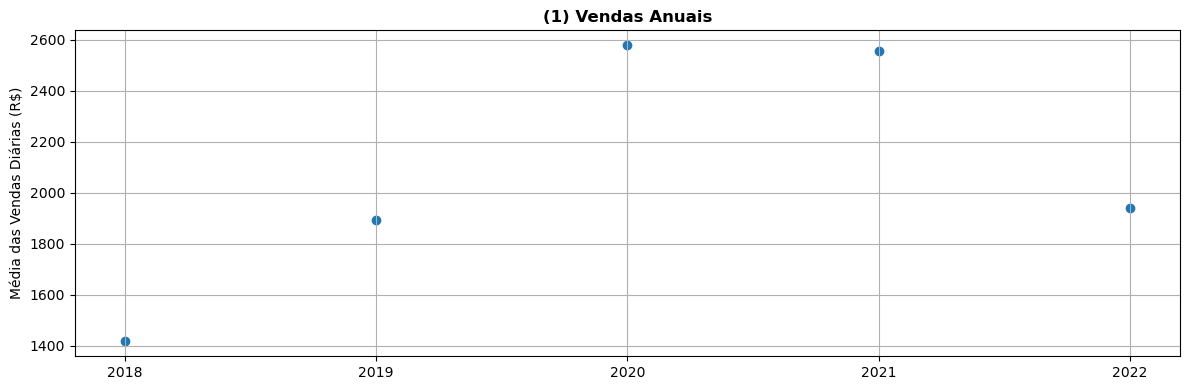

In [167]:
# Vendas Anuais
plt.figure(figsize=(12,4))
temp = df.groupby(['year']).agg(np.mean).drop(['weeknum','day','month','qtd','weekday','hour'],axis=1)
plt.scatter(temp.index,temp.value)
plt.title('(1) Vendas Anuais',fontweight='bold')
plt.ylabel('Média das Vendas Diárias (R$)')
plt.xticks(np.arange(2018, 2023, 1))
locs, _ = plt.xticks()
#plt.xticks(locs, ['Segunda','Terça','Quarta','Quinta','Sexta','Sábado'])
plt.tight_layout()
plt.grid()

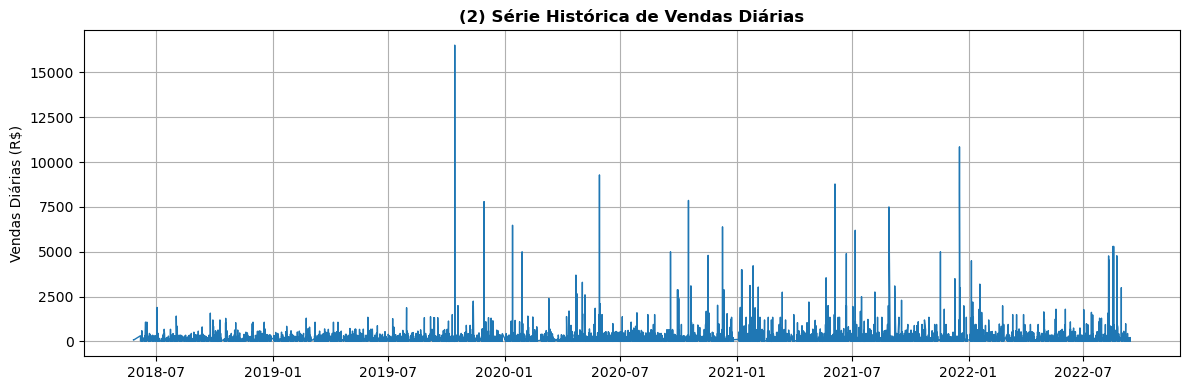

In [168]:
# Série Histórica de Vendas Diárias
plt.figure(figsize=(12,4))
plt.plot(inputProphet, linewidth=1)
plt.title('(2) Série Histórica de Vendas Diárias',fontweight='bold')
plt.ylabel('Vendas Diárias (R$)')
plt.tight_layout()
plt.grid()

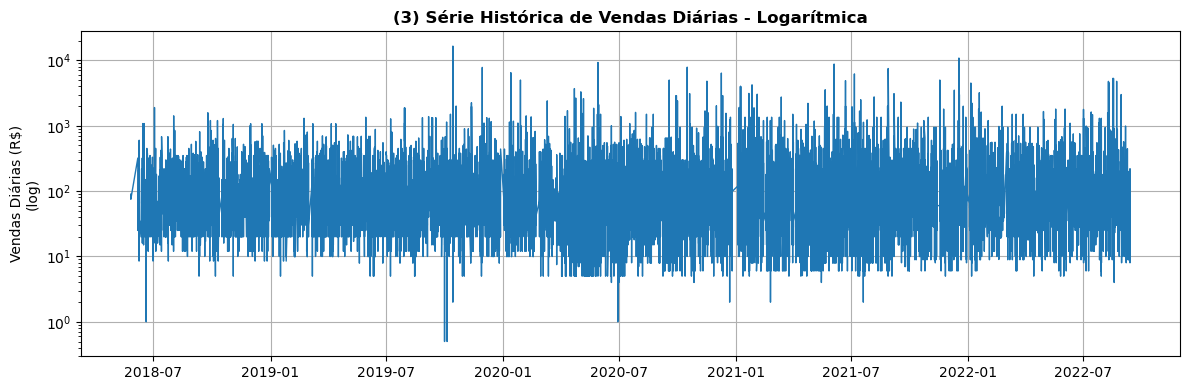

In [169]:
# Série Histórica de Vendas Diárias - Logarítmica
plt.figure(figsize=(12,4))
plt.plot(inputProphet, linewidth=1)
plt.yscale("log") 
plt.title('(3) Série Histórica de Vendas Diárias - Logarítmica',fontweight='bold')
plt.ylabel('Vendas Diárias (R$)\n(log)')
plt.tight_layout()
plt.grid()

<div align='justify'>
Os gráficos <b>(4)</b>, <b>(5)</b>, <b>(6)</b> e <b>(7)</b> têm como objetivo comparar, em diferentes escalas (diário, diário logarítmo, semanal e mensal respectivamente), as vendas nos anos de 2018, 2019, 2020, 2021 e 2022. A necessidade do gráfico logarítmico <b>(5)</b> justificou-se pelo mesmo motivo do gráfico <b>(3)</b>. <br>
Nesses gráficos, há uma dificuldade em observar correlações expressivas entre anos e sazonalidades. Os gráficos diários <b>(4)</b> e <b>(5)</b> são extremamente ruidosos; enquanto os <b>(6)</b> e <b>(7)</b> são inconclusivos, com uma leve exceção no gráfico <b>(7)</b> no que tange aos meses de janeiro, fevereiro e dezembro. Há, nesse intervalo de tempo, um pequeno aumento médio nas vendas, provavelmente relacionado ao natal e ao ano novo.
<br>
Além disso, os gráficos <b>(5)</b>, <b>(6)</b> e <b>(7)</b> conseguem evidenciar bem o baixo faturamento em 2018 ocasionado pela abertura da loja, período de adaptação e conquista de mercado.
    

</div>

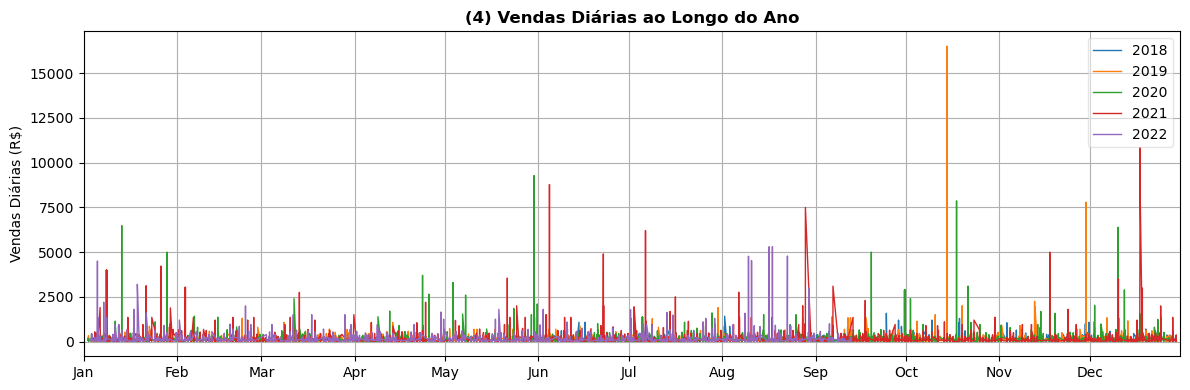

In [170]:
# Vendas Diárias ao Longo do Ano
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(inputProphet[inputProphet.index.year==2018].index                           , inputProphet[inputProphet.index.year==2018]['Total do Item'], label = '2018', linewidth=1)
ax.plot(inputProphet[inputProphet.index.year==2019].index - np.timedelta64( 365,'D'), inputProphet[inputProphet.index.year==2019]['Total do Item'], label = '2019', linewidth=1)
ax.plot(inputProphet[inputProphet.index.year==2020].index - np.timedelta64( 730,'D'), inputProphet[inputProphet.index.year==2020]['Total do Item'], label = '2020', linewidth=1)
ax.plot(inputProphet[inputProphet.index.year==2021].index - np.timedelta64(1096,'D'), inputProphet[inputProphet.index.year==2021]['Total do Item'], label = '2021', linewidth=1)
ax.plot(inputProphet[inputProphet.index.year==2022].index - np.timedelta64(1461,'D'), inputProphet[inputProphet.index.year==2022]['Total do Item'], label = '2022', linewidth=1)
ax.set_title('(4) Vendas Diárias ao Longo do Ano',fontweight='bold')
ax.set_ylabel('Vendas Diárias (R$)')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.set_xlim(np.datetime64('2018-01-01T00:00:00.000000000'),np.datetime64('2018-12-31T00:00:00.000000000'))
plt.tight_layout()
plt.legend(framealpha=0.5)
plt.grid()

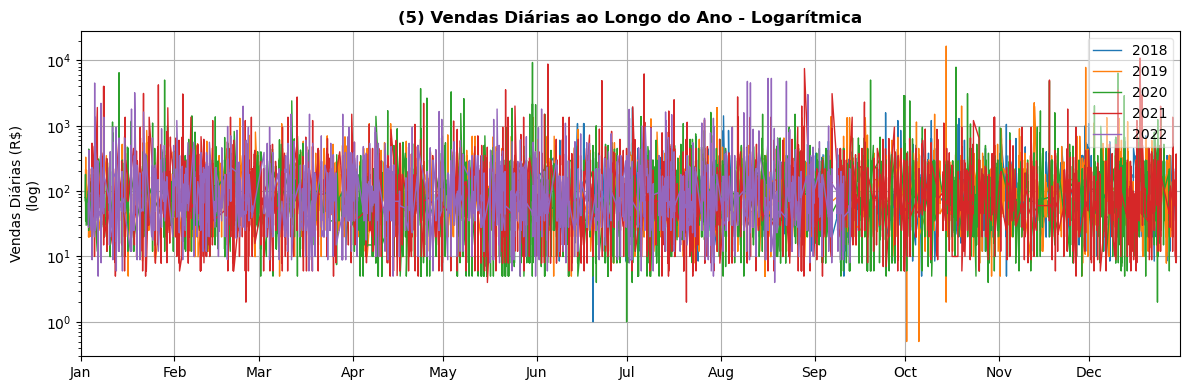

In [171]:
# Vendas Diárias ao Longo do Ano - Logarítmica
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(inputProphet[inputProphet.index.year==2018].index                           , inputProphet[inputProphet.index.year==2018]['Total do Item'], label = '2018', linewidth=1)
ax.plot(inputProphet[inputProphet.index.year==2019].index - np.timedelta64( 365,'D'), inputProphet[inputProphet.index.year==2019]['Total do Item'], label = '2019', linewidth=1)
ax.plot(inputProphet[inputProphet.index.year==2020].index - np.timedelta64( 730,'D'), inputProphet[inputProphet.index.year==2020]['Total do Item'], label = '2020', linewidth=1)
ax.plot(inputProphet[inputProphet.index.year==2021].index - np.timedelta64(1096,'D'), inputProphet[inputProphet.index.year==2021]['Total do Item'], label = '2021', linewidth=1)
ax.plot(inputProphet[inputProphet.index.year==2022].index - np.timedelta64(1461,'D'), inputProphet[inputProphet.index.year==2022]['Total do Item'], label = '2022', linewidth=1)
ax.set_title('(5) Vendas Diárias ao Longo do Ano - Logarítmica',fontweight='bold')
ax.set_ylabel('Vendas Diárias (R$)\n(log)')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.set_xlim(np.datetime64('2018-01-01T00:00:00.000000000'),np.datetime64('2018-12-31T00:00:00.000000000'))
plt.yscale("log") 
plt.tight_layout()
plt.legend(framealpha=0.5)
plt.grid()

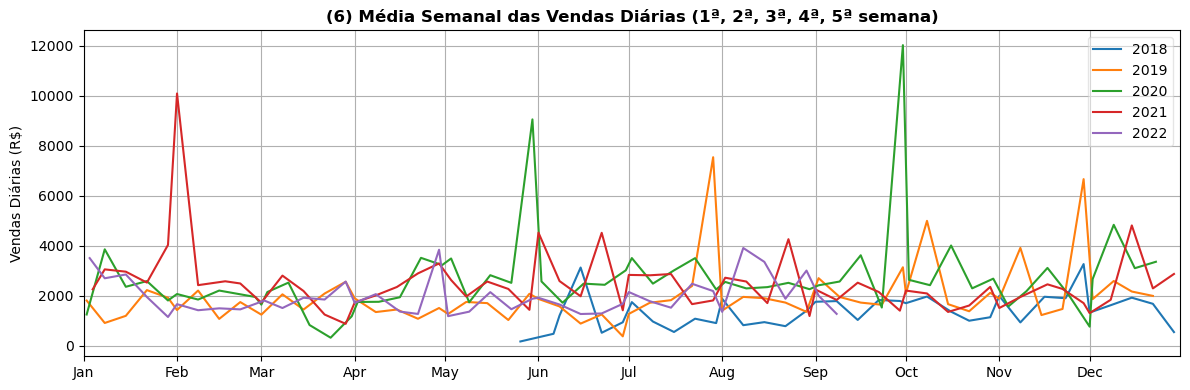

In [172]:
# Média Semanal das Vendas Diárias (1ª, 2ª, 3ª, 4ª, 5ª semana)
temp = df[['datetime','weeknum']]
droplist = []
for i in range(len(temp)-1):
    if temp['weeknum'].iloc[i+1] == temp['weeknum'].iloc[i]:
        droplist.append(i+1)
temp = temp.drop(droplist,axis=0).reset_index(drop=True)
df_ = df.groupby(['year','month','weeknum']).agg(np.mean).drop(['weekday','day','qtd','hour'],axis=1)
df_['date'] = temp.datetime.values

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(df_.loc[2018].date                           , df_.loc[2018].value, label = '2018')
ax.plot(df_.loc[2019].date - np.timedelta64( 365,'D'), df_.loc[2019].value, label = '2019')
ax.plot(df_.loc[2020].date - np.timedelta64( 730,'D'), df_.loc[2020].value, label = '2020')
ax.plot(df_.loc[2021].date - np.timedelta64(1096,'D'), df_.loc[2021].value, label = '2021')
ax.plot(df_.loc[2022].date - np.timedelta64(1461,'D'), df_.loc[2022].value, label = '2022')
ax.set_title('(6) Média Semanal das Vendas Diárias (1ª, 2ª, 3ª, 4ª, 5ª semana)',fontweight='bold')
ax.set_ylabel('Vendas Diárias (R$)')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.set_xlim(np.datetime64('2018-01-01T00:00:00.000000000'),np.datetime64('2018-12-31T00:00:00.000000000'))
#plt.yscale("log") 
plt.tight_layout()
plt.legend(framealpha=0.5)
plt.grid()

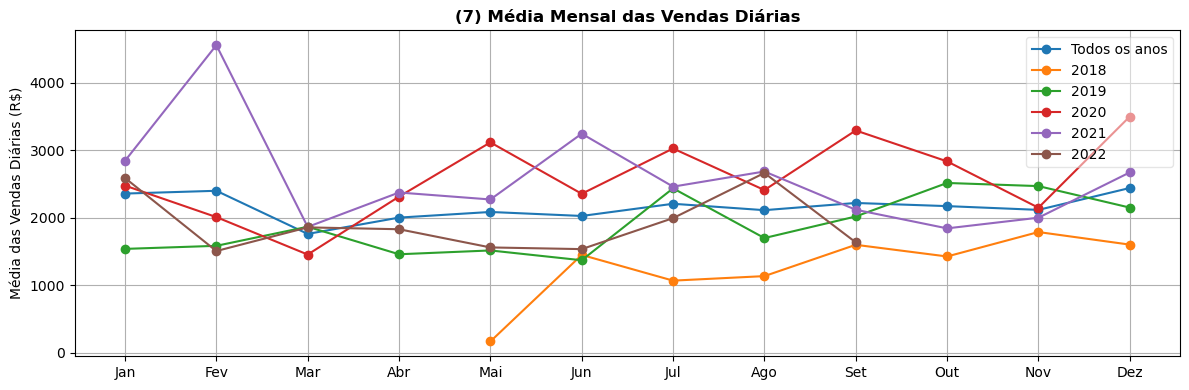

In [173]:
# (6) Média Mensal das Vendas Diárias
plt.figure(figsize=(12,4))
plt.plot(df.groupby(['month']).agg(np.mean).drop(['weekday','day','year','weeknum','qtd','hour'],axis=1), marker='o', label='Todos os anos')
plt.plot(df.groupby(['year','month']).agg(np.mean).drop(['weekday','day','weeknum','qtd','hour'],axis=1).loc[2018], marker='o', label='2018')
plt.plot(df.groupby(['year','month']).agg(np.mean).drop(['weekday','day','weeknum','qtd','hour'],axis=1).loc[2019], marker='o', label='2019')
plt.plot(df.groupby(['year','month']).agg(np.mean).drop(['weekday','day','weeknum','qtd','hour'],axis=1).loc[2020], marker='o', label='2020')
plt.plot(df.groupby(['year','month']).agg(np.mean).drop(['weekday','day','weeknum','qtd','hour'],axis=1).loc[2021], marker='o', label='2021')
plt.plot(df.groupby(['year','month']).agg(np.mean).drop(['weekday','day','weeknum','qtd','hour'],axis=1).loc[2022], marker='o', label='2022')
plt.title('(7) Média Mensal das Vendas Diárias',fontweight='bold')
plt.ylabel('Média das Vendas Diárias (R$)')
plt.xticks(np.arange(1, 13, 1))
locs, _=plt.xticks()
plt.xticks(locs,['Jan','Fev','Mar','Abr','Mai','Jun','Jul','Ago','Set','Out','Nov','Dez'])
plt.tight_layout()
plt.legend(framealpha=0.5)
plt.grid()

<div align='justify'>
Os gráficos <b>(8)</b>, <b>(9)</b> e <b>(10)</b> têm como objetivo buscar evidenciar comportamentos de clientes a curto prazo. Os gráficos <b>(8)</b> e <b>(9)</b> tem como proposta saber se a semana e o dia do mês, respectivamente, influenciam no fluxo de caixa da empresa. E de fato influencia, pois na quinta semana do mês (dias 29, 30, 31) as vendas ocorrem de forma mais afortunada. A quarta semana (dias 15 até 28) costuma ser a mais tênue do mês. Já o gráfico <b>(10)</b> tem como objetivo saber como as vendas ocorrem ao longo da semana. A quinta feira, por exemplo, tende a ser o dia menos movimentado; e em contrapartida, a sexta feira é o dia que ocorrem vendas de maior valor.


</div>

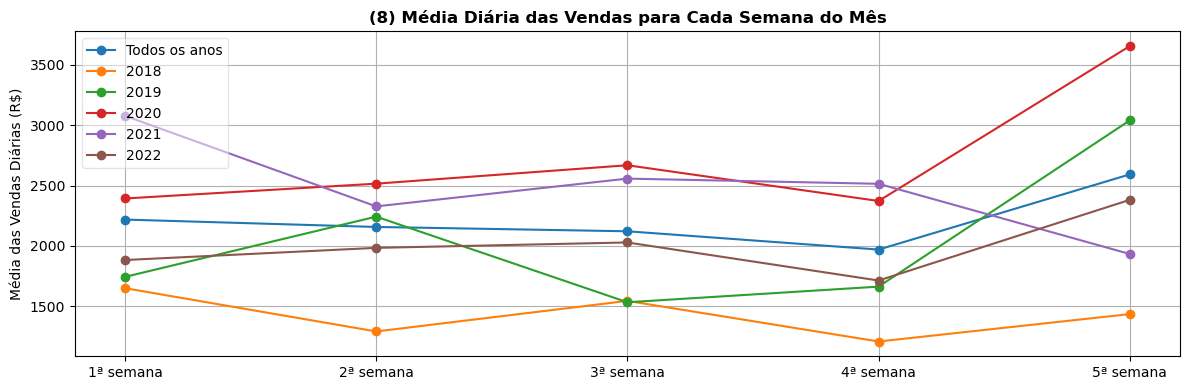

In [174]:
# Média Diária das Vendas para Cada Semana do Mês
plt.figure(figsize=(12,4))
plt.plot(df.groupby(['weeknum']).agg(np.mean).drop(['weekday','day','month','year','qtd','hour'],axis=1), marker='o', label='Todos os anos')
plt.plot(df.groupby(['year','weeknum']).agg(np.mean).drop(['weekday','day','month','qtd','hour'],axis=1).loc[2018], marker='o', label='2018')
plt.plot(df.groupby(['year','weeknum']).agg(np.mean).drop(['weekday','day','month','qtd','hour'],axis=1).loc[2019], marker='o', label='2019')
plt.plot(df.groupby(['year','weeknum']).agg(np.mean).drop(['weekday','day','month','qtd','hour'],axis=1).loc[2020], marker='o', label='2020')
plt.plot(df.groupby(['year','weeknum']).agg(np.mean).drop(['weekday','day','month','qtd','hour'],axis=1).loc[2021], marker='o', label='2021')
plt.plot(df.groupby(['year','weeknum']).agg(np.mean).drop(['weekday','day','month','qtd','hour'],axis=1).loc[2022], marker='o', label='2022')
plt.title('(8) Média Diária das Vendas para Cada Semana do Mês',fontweight='bold')
plt.ylabel('Média das Vendas Diárias (R$)')
plt.xticks(np.arange(1, 6, 1))
locs, _=plt.xticks()
plt.xticks(locs, ['1ª semana','2ª semana','3ª semana','4ª semana','5ª semana'])
plt.tight_layout()
plt.legend(framealpha=0.5)
plt.grid()

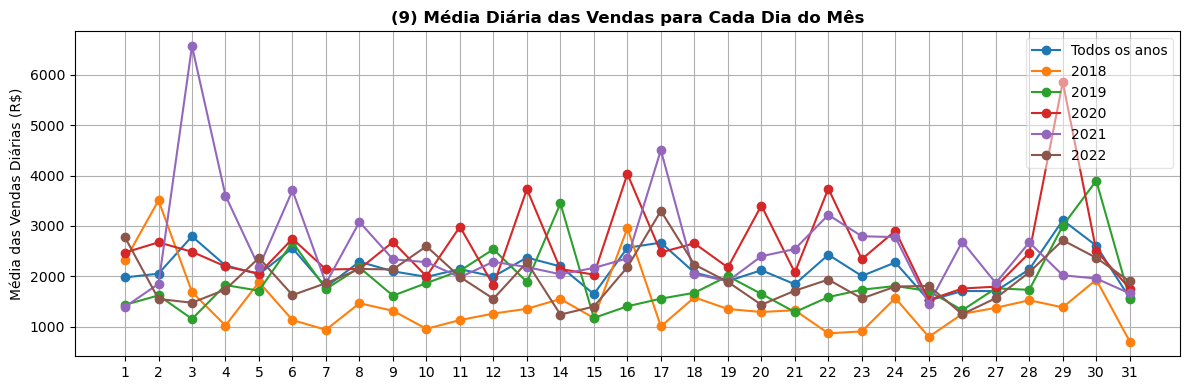

In [175]:
# Média Diária das Vendas para Cada Dia do Mês
plt.figure(figsize=(12,4))
plt.plot(df.groupby(['day']).agg(np.mean).drop(['weekday','month','year','weeknum','qtd','hour'],axis=1), marker='o', label='Todos os anos')
plt.plot(df.groupby(['year','day']).agg(np.mean).drop(['weekday','month','weeknum','qtd','hour'],axis=1).loc[2018], marker='o', label='2018')
plt.plot(df.groupby(['year','day']).agg(np.mean).drop(['weekday','month','weeknum','qtd','hour'],axis=1).loc[2019], marker='o', label='2019')
plt.plot(df.groupby(['year','day']).agg(np.mean).drop(['weekday','month','weeknum','qtd','hour'],axis=1).loc[2020], marker='o', label='2020')
plt.plot(df.groupby(['year','day']).agg(np.mean).drop(['weekday','month','weeknum','qtd','hour'],axis=1).loc[2021], marker='o', label='2021')
plt.plot(df.groupby(['year','day']).agg(np.mean).drop(['weekday','month','weeknum','qtd','hour'],axis=1).loc[2022], marker='o', label='2022')
plt.title('(9) Média Diária das Vendas para Cada Dia do Mês',fontweight='bold')
plt.ylabel('Média das Vendas Diárias (R$)')
plt.xticks(np.arange(1, 32, 1))
plt.tight_layout()
plt.legend(framealpha=0.5)
plt.grid()

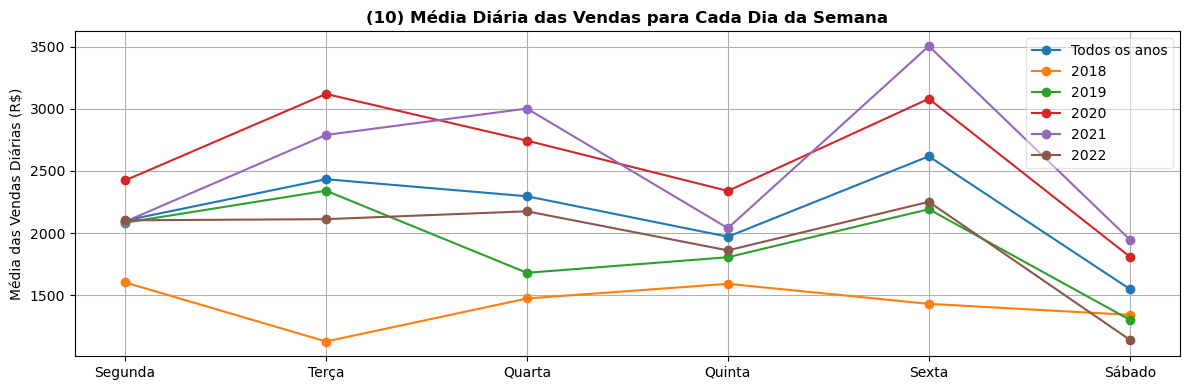

In [176]:
# Média Diária das Vendas para Cada Dia da Semana
plt.figure(figsize=(12,4))
plt.plot(df.groupby('weekday').agg(np.mean).drop(['year','weeknum','day','month','qtd','hour'],axis=1).drop([6]), marker='o', label='Todos os anos')
plt.plot(df.groupby(['year','weekday']).agg(np.mean).drop(['weeknum','day','month','qtd','hour'],axis=1).loc[2018].drop([6]), marker='o', label='2018')
plt.plot(df.groupby(['year','weekday']).agg(np.mean).drop(['weeknum','day','month','qtd','hour'],axis=1).loc[2019].drop([6]), marker='o', label='2019')
plt.plot(df.groupby(['year','weekday']).agg(np.mean).drop(['weeknum','day','month','qtd','hour'],axis=1).loc[2020], marker='o', label='2020')
plt.plot(df.groupby(['year','weekday']).agg(np.mean).drop(['weeknum','day','month','qtd','hour'],axis=1).loc[2021].drop([6]), marker='o', label='2021')
plt.plot(df.groupby(['year','weekday']).agg(np.mean).drop(['weeknum','day','month','qtd','hour'],axis=1).loc[2022], marker='o', label='2022')
plt.title('(10) Média Diária das Vendas para Cada Dia da Semana',fontweight='bold')
plt.ylabel('Média das Vendas Diárias (R$)')
plt.xticks(np.arange(0, 6, 1))
locs, _ = plt.xticks()
plt.xticks(locs, ['Segunda','Terça','Quarta','Quinta','Sexta','Sábado'])
plt.tight_layout()
plt.legend(framealpha=0.5)
plt.grid()

<div align='justify'>

Os gráficos <b>(11)</b>, <b>(12)</b> e <b>(13)</b> têm como objetivo mostrar a distribuição da quantidade diária de clientes que a loja recebe, tanto historicamente quanto ao longo do ano, respectivamente. Como o gráfico <b>(12)</b> é muito ruidoso, foi aplicada uma média móvel nos dados (gráfico <b>(13)</b>). Dessa forma, é possível identificar comportamentos da curva semelhantes nos anos de 2019 e 2022, e 2020 e 2021. Já o gráfico <b>(14)</b> mostra a distrifuição em frequência da quantidade de clientes que compram com a empresa. As distribuições são bem semelhantes no intervalo de ocorrência, e todas com desvio padrão alto, o que corrobora a ruidosidade do gráfico <b>(12)</b>. Entretanto, foi o ano de 2019 que apresentou a amior média de clientes dentre todos os anos.
    
    
</div>

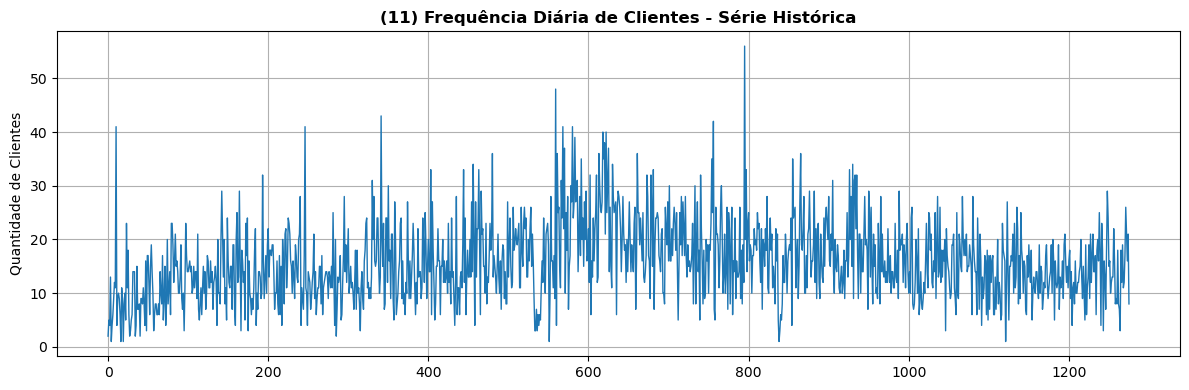

In [177]:
# Frequência Diária de Clientes - Série Histórica
plt.figure(figsize=(12,4))
plt.plot(df['qtd'], linewidth=1)
plt.title('(11) Frequência Diária de Clientes - Série Histórica',fontweight='bold')
plt.ylabel('Quantidade de Clientes')
plt.tight_layout()
plt.grid()

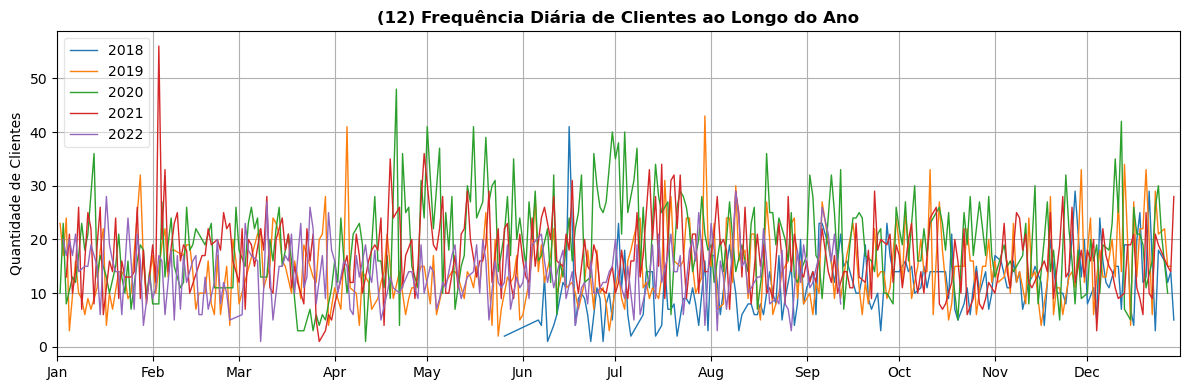

In [178]:
# (12) Frequência Diária de Clientes ao Longo do Ano
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(df[df['datetime'].dt.year==2018]['datetime']                           , df[df['datetime'].dt.year==2018]['qtd'], linewidth = 1, label = '2018')
ax.plot(df[df['datetime'].dt.year==2019]['datetime'] - np.timedelta64( 365,'D'), df[df['datetime'].dt.year==2019]['qtd'], linewidth = 1, label = '2019')
ax.plot(df[df['datetime'].dt.year==2020]['datetime'] - np.timedelta64( 730,'D'), df[df['datetime'].dt.year==2020]['qtd'], linewidth = 1, label = '2020')
ax.plot(df[df['datetime'].dt.year==2021]['datetime'] - np.timedelta64(1096,'D'), df[df['datetime'].dt.year==2021]['qtd'], linewidth = 1, label = '2021')
ax.plot(df[df['datetime'].dt.year==2022]['datetime'] - np.timedelta64(1461,'D'), df[df['datetime'].dt.year==2022]['qtd'], linewidth = 1, label = '2022')
ax.set_title('(12) Frequência Diária de Clientes ao Longo do Ano',fontweight='bold')
ax.set_ylabel('Quantidade de Clientes')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.set_xlim(np.datetime64('2018-01-01T00:00:00.000000000'),np.datetime64('2018-12-31T00:00:00.000000000'))
plt.tight_layout()
plt.legend(framealpha=0.5)
plt.grid()

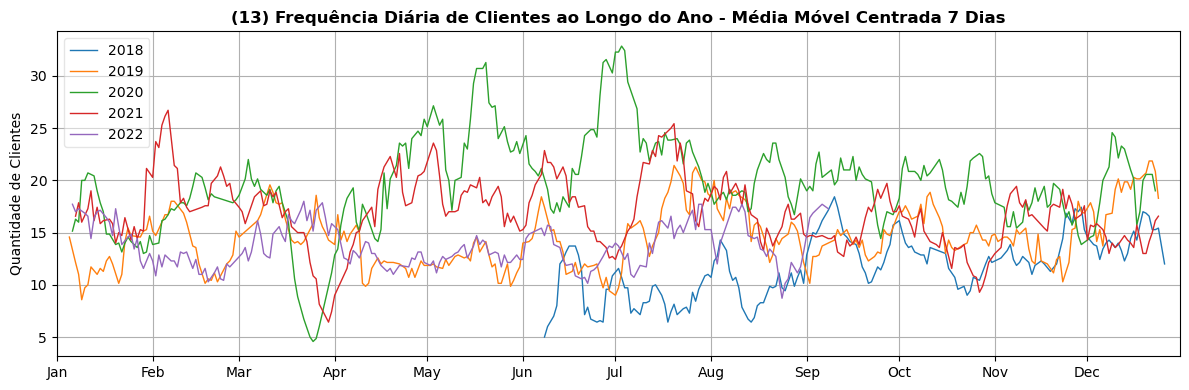

In [179]:
# (13) Frequência Diária de Clientes ao Longo do Ano - Média Móvel Centrada 7 Dias
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(df[df['datetime'].dt.year==2018]['datetime']                           , df[df['datetime'].dt.year==2018]['qtd'].rolling(window=7,center=True).mean(), linewidth = 1, label = '2018')
ax.plot(df[df['datetime'].dt.year==2019]['datetime'] - np.timedelta64( 365,'D'), df[df['datetime'].dt.year==2019]['qtd'].rolling(window=7,center=True).mean(), linewidth = 1, label = '2019')
ax.plot(df[df['datetime'].dt.year==2020]['datetime'] - np.timedelta64( 730,'D'), df[df['datetime'].dt.year==2020]['qtd'].rolling(window=7,center=True).mean(), linewidth = 1, label = '2020')
ax.plot(df[df['datetime'].dt.year==2021]['datetime'] - np.timedelta64(1096,'D'), df[df['datetime'].dt.year==2021]['qtd'].rolling(window=7,center=True).mean(), linewidth = 1, label = '2021')
ax.plot(df[df['datetime'].dt.year==2022]['datetime'] - np.timedelta64(1461,'D'), df[df['datetime'].dt.year==2022]['qtd'].rolling(window=7,center=True).mean(), linewidth = 1, label = '2022')
ax.set_title('(13) Frequência Diária de Clientes ao Longo do Ano - Média Móvel Centrada 7 Dias',fontweight='bold')
ax.set_ylabel('Quantidade de Clientes')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.set_xlim(np.datetime64('2018-01-01T00:00:00.000000000'),np.datetime64('2018-12-31T00:00:00.000000000'))
plt.tight_layout()
plt.legend(framealpha=0.5)
plt.grid()

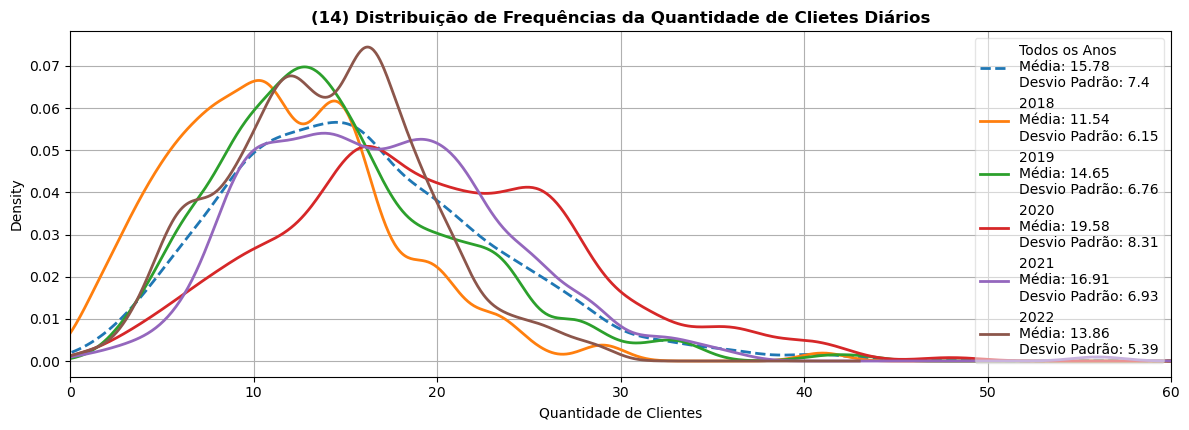

In [180]:
# (14) Distribuição de Frequências da Quantidade de Clietes Diários
plt.figure(figsize=(12,4.4))
bw = 0.2
df['qtd']                              .plot.kde(bw_method=bw, linewidth = 2, label = f"Todos os Anos\nMédia: {np.round(df['qtd'].mean(),2)}\nDesvio Padrão: {np.round(df['qtd'].std(),2)}", linestyle = 'dashed')
df[df['datetime'].dt.year==2018]['qtd'].plot.kde(bw_method=bw, linewidth = 2, label = f"2018\nMédia: {np.round(df[df['datetime'].dt.year==2018]['qtd'].mean(),2)}\nDesvio Padrão: {np.round(df[df['datetime'].dt.year==2018]['qtd'].std(),2)}")
df[df['datetime'].dt.year==2019]['qtd'].plot.kde(bw_method=bw, linewidth = 2, label = f"2019\nMédia: {np.round(df[df['datetime'].dt.year==2019]['qtd'].mean(),2)}\nDesvio Padrão: {np.round(df[df['datetime'].dt.year==2019]['qtd'].std(),2)}")
df[df['datetime'].dt.year==2020]['qtd'].plot.kde(bw_method=bw, linewidth = 2, label = f"2020\nMédia: {np.round(df[df['datetime'].dt.year==2020]['qtd'].mean(),2)}\nDesvio Padrão: {np.round(df[df['datetime'].dt.year==2020]['qtd'].std(),2)}")
df[df['datetime'].dt.year==2021]['qtd'].plot.kde(bw_method=bw, linewidth = 2, label = f"2021\nMédia: {np.round(df[df['datetime'].dt.year==2021]['qtd'].mean(),2)}\nDesvio Padrão: {np.round(df[df['datetime'].dt.year==2021]['qtd'].std(),2)}")
df[df['datetime'].dt.year==2022]['qtd'].plot.kde(bw_method=bw, linewidth = 2, label = f"2022\nMédia: {np.round(df[df['datetime'].dt.year==2022]['qtd'].mean(),2)}\nDesvio Padrão: {np.round(df[df['datetime'].dt.year==2022]['qtd'].std(),2)}")
plt.xlim(0,60)
plt.title('(14) Distribuição de Frequências da Quantidade de Clietes Diários', fontweight='bold')
plt.xlabel('Quantidade de Clientes')
plt.tight_layout()
plt.legend(framealpha=0.5)
plt.grid()

<div align='justify'>

Os gráficos <b>(15)</b> e <b>(16)</b> mostram, em escala diferente dos gráficos <b>(12)</b> e <b>(13)</b>, a frequência média diária de clientes em relação à semana do mês e ao mês respectivamente. O gráfico <b>(15)</b> mostra comportamento semelhante ao gráfico <b>(13)</b>: comportamentos da curva semelhantes nos anos de 2019 e 2022, e 2020 e 2021. Entretanto esse mesmo padrão não é observado no gráfico <b>(16)</b>, provavelmente pela média mensal ter 'diluído' e 'homogeneizado' tal comportamento. Já os gráficos <b>(17)</b>, <b>(18)</b> e <b>(19)</b> têm como objetivo evidenciar a frequência diária média da quantidade de clientes em curtos intervalos temporais, buscando algum tipo de sazonalidade em relação à semana do mês, ao dia do mês e ao dia da semana, respectivamente. A frequência média para esses três gráficos é, em linhas gerais, ruidosa (alto desvio padrão, como observado no gráfico <b>(14)</b>) e não apresenta grandes variações entre as observações anuais. A única discrepância ocorre no gráfico <b>(19)</b>, aos sábados, e é justificada pela loja abrir somente meio período nesse dia da semana.
   <br> 
   Além disso, é interessante ressaltar que o gráfico <b>(10)</b> mostrou uma diferença significativa na quinta-feira (poucas vendas) e na sexta-feira (muitas vendas), e essa distinção não aparece na frequência diária de clientes. Ou seja, por mais que o fluxo de clientes não varie muito, eles costumam comprar produtos mais caros na sexta-feira e mais baratos na quinta-feira.
    

</div>

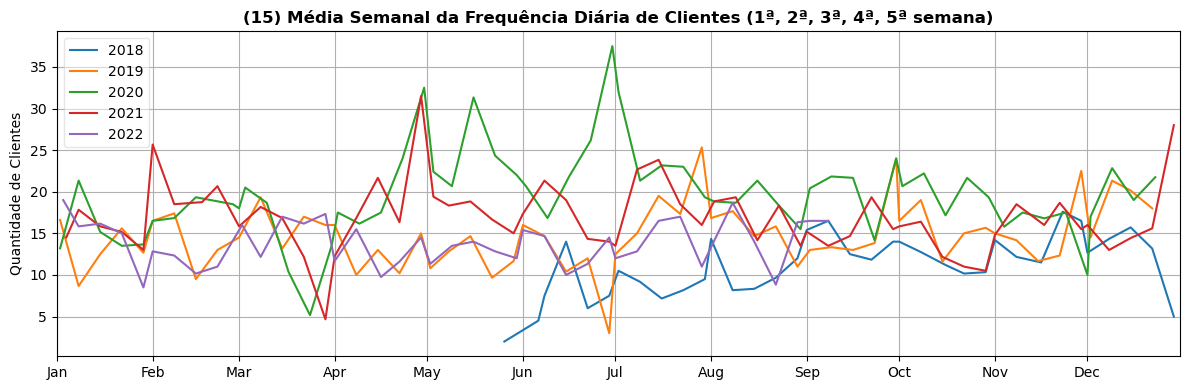

In [181]:
# (15) Média Semanal da Frequência Diária de Clientes (1ª, 2ª, 3ª, 4ª, 5ª semana)

temp = df[['datetime','weeknum']]
droplist = []
for i in range(len(temp)-1):
    if temp['weeknum'].iloc[i+1] == temp['weeknum'].iloc[i]:
        droplist.append(i+1)
temp = temp.drop(droplist,axis=0).reset_index(drop=True)
df_ = df.groupby(['year','month','weeknum']).agg(np.mean).drop(['weekday','day','value','hour'],axis=1)
df_['date'] = temp.datetime.values

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(df_.loc[2018].date                           , df_.loc[2018]['qtd'], label = '2018')
ax.plot(df_.loc[2019].date - np.timedelta64( 365,'D'), df_.loc[2019]['qtd'], label = '2019')
ax.plot(df_.loc[2020].date - np.timedelta64( 730,'D'), df_.loc[2020]['qtd'], label = '2020')
ax.plot(df_.loc[2021].date - np.timedelta64(1096,'D'), df_.loc[2021]['qtd'], label = '2021')
ax.plot(df_.loc[2022].date - np.timedelta64(1461,'D'), df_.loc[2022]['qtd'], label = '2022')
ax.set_title('(15) Média Semanal da Frequência Diária de Clientes (1ª, 2ª, 3ª, 4ª, 5ª semana)',fontweight='bold')
ax.set_ylabel('Quantidade de Clientes')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.set_xlim(np.datetime64('2018-01-01T00:00:00.000000000'),np.datetime64('2018-12-31T00:00:00.000000000'))
#plt.yscale("log") 
plt.tight_layout()
plt.legend(framealpha=0.5)
plt.grid()

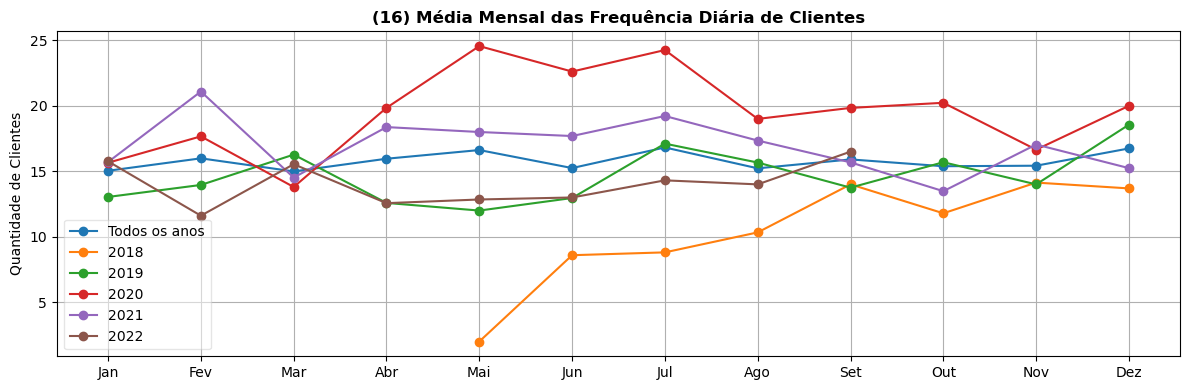

In [182]:
# (16) Média Mensal das Frequência Diária de Clientes
plt.figure(figsize=(12,4))
plt.plot(df.groupby(['month']).agg(np.mean).drop(['weekday','day','year','weeknum','value','hour'],axis=1), marker='o', label='Todos os anos')
plt.plot(df.groupby(['year','month']).agg(np.mean).drop(['weekday','day','weeknum','value','hour'],axis=1).loc[2018], marker='o', label='2018')
plt.plot(df.groupby(['year','month']).agg(np.mean).drop(['weekday','day','weeknum','value','hour'],axis=1).loc[2019], marker='o', label='2019')
plt.plot(df.groupby(['year','month']).agg(np.mean).drop(['weekday','day','weeknum','value','hour'],axis=1).loc[2020], marker='o', label='2020')
plt.plot(df.groupby(['year','month']).agg(np.mean).drop(['weekday','day','weeknum','value','hour'],axis=1).loc[2021], marker='o', label='2021')
plt.plot(df.groupby(['year','month']).agg(np.mean).drop(['weekday','day','weeknum','value','hour'],axis=1).loc[2022], marker='o', label='2022')
plt.title('(16) Média Mensal das Frequência Diária de Clientes',fontweight='bold')
plt.ylabel('Quantidade de Clientes')
plt.xticks(np.arange(1, 13, 1))
locs, _=plt.xticks()
plt.xticks(locs,['Jan','Fev','Mar','Abr','Mai','Jun','Jul','Ago','Set','Out','Nov','Dez'])
plt.tight_layout()
plt.legend(framealpha=0.5)
plt.grid()

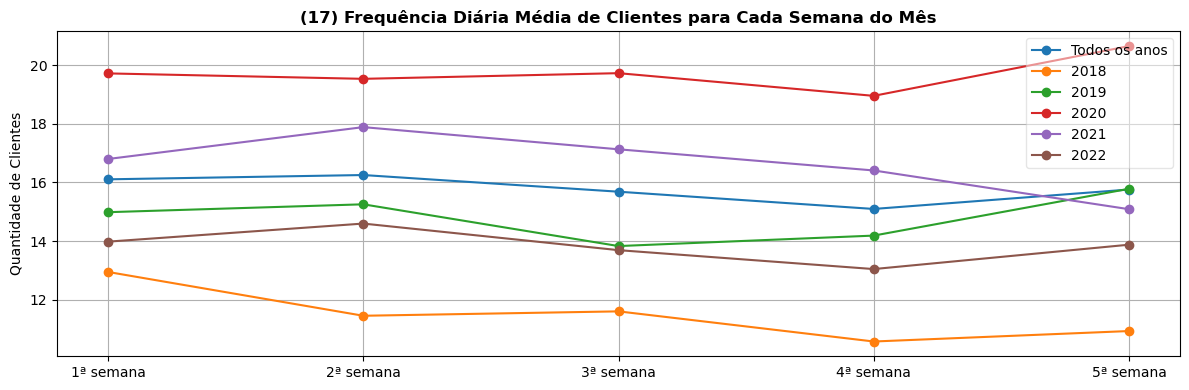

In [183]:
# (17) Frequência Diária Média de Clientes para Cada Semana do Mês
plt.figure(figsize=(12,4))
plt.plot(df.groupby('weeknum').agg(np.mean).drop(['year','weekday','day','month','value','hour'],axis=1), marker='o', label='Todos os anos')
plt.plot(df.groupby(['year','weeknum']).agg(np.mean).drop(['weekday','day','month','value','hour'],axis=1).loc[2018], marker='o', label='2018')
plt.plot(df.groupby(['year','weeknum']).agg(np.mean).drop(['weekday','day','month','value','hour'],axis=1).loc[2019], marker='o', label='2019')
plt.plot(df.groupby(['year','weeknum']).agg(np.mean).drop(['weekday','day','month','value','hour'],axis=1).loc[2020], marker='o', label='2020')
plt.plot(df.groupby(['year','weeknum']).agg(np.mean).drop(['weekday','day','month','value','hour'],axis=1).loc[2021], marker='o', label='2021')
plt.plot(df.groupby(['year','weeknum']).agg(np.mean).drop(['weekday','day','month','value','hour'],axis=1).loc[2022], marker='o', label='2022')
plt.title('(17) Frequência Diária Média de Clientes para Cada Semana do Mês',fontweight='bold')
plt.ylabel('Quantidade de Clientes')
plt.xticks(np.arange(1, 6, 1))
locs, _=plt.xticks()
plt.xticks(locs, ['1ª semana','2ª semana','3ª semana','4ª semana','5ª semana'])
plt.tight_layout()
plt.legend(framealpha=0.5)
plt.grid()

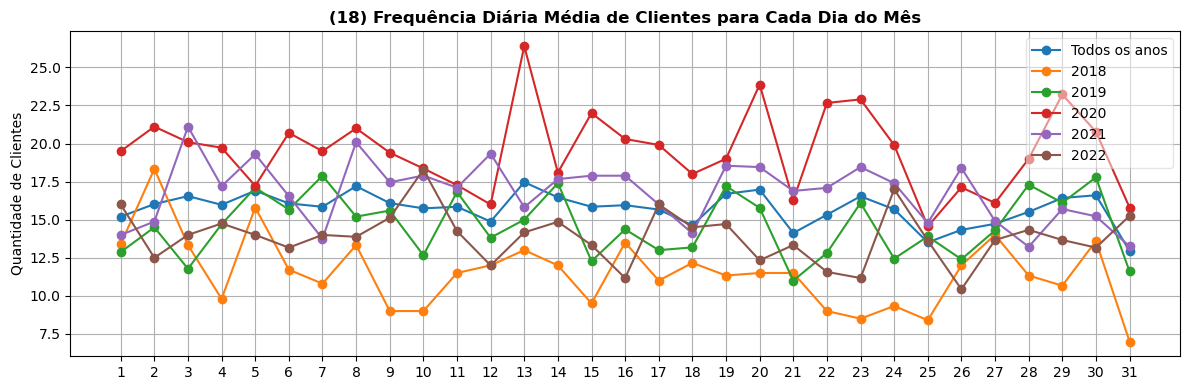

In [184]:
# (18) Frequência Diária Média de Clientes para Cada Dia do Mês
plt.figure(figsize=(12,4))
plt.plot(df.groupby(['day']).agg(np.mean).drop(['weekday','month','year','weeknum','value','hour'],axis=1), marker='o', label='Todos os anos')
plt.plot(df.groupby(['year','day']).agg(np.mean).drop(['weekday','month','weeknum','value','hour'],axis=1).loc[2018], marker='o', label='2018')
plt.plot(df.groupby(['year','day']).agg(np.mean).drop(['weekday','month','weeknum','value','hour'],axis=1).loc[2019], marker='o', label='2019')
plt.plot(df.groupby(['year','day']).agg(np.mean).drop(['weekday','month','weeknum','value','hour'],axis=1).loc[2020], marker='o', label='2020')
plt.plot(df.groupby(['year','day']).agg(np.mean).drop(['weekday','month','weeknum','value','hour'],axis=1).loc[2021], marker='o', label='2021')
plt.plot(df.groupby(['year','day']).agg(np.mean).drop(['weekday','month','weeknum','value','hour'],axis=1).loc[2022], marker='o', label='2022')
plt.title('(18) Frequência Diária Média de Clientes para Cada Dia do Mês',fontweight='bold')
plt.ylabel('Quantidade de Clientes')
plt.xticks(np.arange(1, 32, 1))
plt.tight_layout()
plt.legend(framealpha=0.5)
plt.grid()

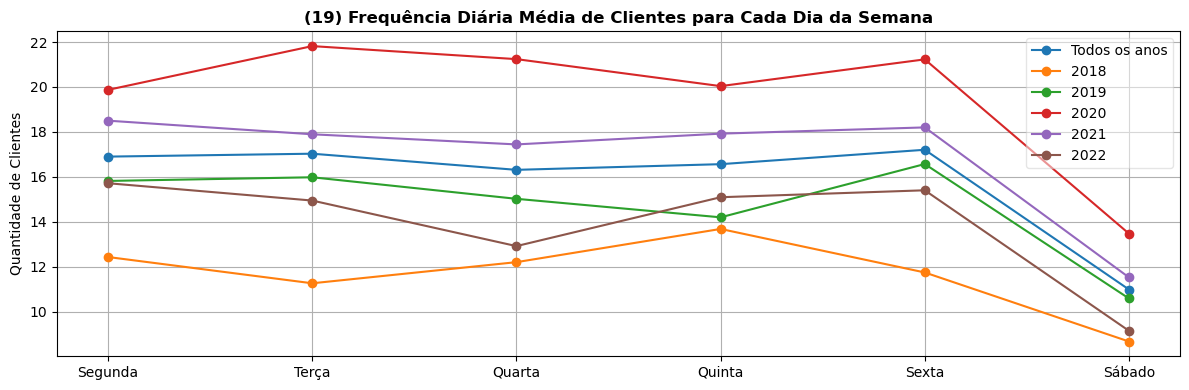

In [185]:
# (19) Frequência Diária Média de Clientes para Cada Dia da Semana
plt.figure(figsize=(12,4))
plt.plot(df.groupby('weekday').agg(np.mean).drop(['year','weeknum','day','month','value','hour'],axis=1).drop([6]), marker='o', label='Todos os anos')
plt.plot(df.groupby(['year','weekday']).agg(np.mean).drop(['weeknum','day','month','value','hour'],axis=1).loc[2018].drop([6]), marker='o', label='2018')
plt.plot(df.groupby(['year','weekday']).agg(np.mean).drop(['weeknum','day','month','value','hour'],axis=1).loc[2019].drop([6]), marker='o', label='2019')
plt.plot(df.groupby(['year','weekday']).agg(np.mean).drop(['weeknum','day','month','value','hour'],axis=1).loc[2020], marker='o', label='2020')
plt.plot(df.groupby(['year','weekday']).agg(np.mean).drop(['weeknum','day','month','value','hour'],axis=1).loc[2021].drop([6]), marker='o', label='2021')
plt.plot(df.groupby(['year','weekday']).agg(np.mean).drop(['weeknum','day','month','value','hour'],axis=1).loc[2022], marker='o', label='2022')
plt.title('(19) Frequência Diária Média de Clientes para Cada Dia da Semana',fontweight='bold')
plt.ylabel('Quantidade de Clientes')
plt.xticks(np.arange(0, 6, 1))
locs, _ = plt.xticks()
plt.xticks(locs, ['Segunda','Terça','Quarta','Quinta','Sexta','Sábado'])
plt.tight_layout()
plt.legend(framealpha=0.5)
plt.grid()

In [1]:
#plt.figure(figsize=(12,4))
#plt.plot(temp                .groupby('hora').agg(np.mean).drop(['ano'],axis=1),label='Todos os anos')
#plt.plot(temp[temp.ano==2018].groupby('hora').agg(np.mean).drop(['ano'],axis=1),label='2018')
#plt.plot(temp[temp.ano==2019].groupby('hora').agg(np.mean).drop(['ano'],axis=1),label='2019')
#plt.plot(temp[temp.ano==2020].groupby('hora').agg(np.mean).drop(['ano'],axis=1),label='2020')
#plt.plot(temp[temp.ano==2021].groupby('hora').agg(np.mean).drop(['ano'],axis=1),label='2021')
#plt.plot(temp[temp.ano==2022].groupby('hora').agg(np.mean).drop(['ano'],axis=1),label='2022')

#plt.xlim(9,19)
#plt.ylim(0,400)

#plt.grid()

In [96]:
#from sklearn.metrics import mean_squared_error 
#from math import sqrt
#rmse = sqrt(mean_squared_error(validacao.y, forecast.yhat))
#print('Teste RSME: %.3f' % rmse)

In [97]:
#from efficient_apriori import apriori

#itemsets, rules = apriori([tuple(x) for x in input_transaction.Produto.to_list()], min_support=0.0001, min_confidence=0.1)
#print(len(rules))

In [98]:
# Print out every rule with 2 items on the left hand side,
# 1 item on the right hand side, sorted by lift
# rules_rhs = filter(lambda rule: len(rule.lhs) == 2 and len(rule.rhs) == 1, rules)

#rules_rhs = rules
#for rule in sorted(rules_rhs, key=lambda rule: rule.lift, reverse=True):
#  print(rule) 